In [2]:
#@title Código Sequencer
#######################################################################################################################
####################################################### IMPORTS #######################################################
#######################################################################################################################

import os
import shutil
import pickle

import numpy
import time
import networkx as nx
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.stats import wasserstein_distance
from scipy.stats import energy_distance
from scipy.stats import entropy
from scipy.interpolate import interp1d
from joblib import Parallel, delayed, dump, load
import multiprocessing

#from sequencer.distance_metrics import return_emd_mat_brute_force, return_energy_mat, return_kl_mat, return_L2_mat

#######################################################################################################################
##  Sequencer Class                                                                                                  ##
#######################################################################################################################

class Sequencer(object):
    """An algorithm that detects one-dimensional trends (sequences) in complex datasets. To do so, To do so, it 
    reorders objects within a set to produce the most elongated manifold describing their similarities which are 
    measured in a multi-scale manner and using a collection of metrics. 

    Parameters
    ----------
    :param grid: numpy.ndarray(), the x-axis of the objects in the sample. The grid should consist of float values
                 and should not contain nan or infinite values. Since the data is assumed to be either 1D (vectors) 
                 or 2D (matrices), the grid is assumed to be 1D or 2D as well.

    :param objects_list: numpy.ndarray(), the list of the objects to sequence. The objects are
                         assumed to be interpolated to a common grid and should not contain nan of infinite values.
                         The data is assumed to be 1 or 2 dimensional, therefore the objects list should have 2 or 
                         3 dimensions.

    :param estimator_list: list of strings (default=['EMD', 'energy', 'KL', 'L2']) , a list of estimators to be used f
                           or the distance assignment. The current available estimators are: 'EMD', 'energy', 'KL', and 'L2'. 

    :param scale_list: list of integers or None (default=None). A list of the scales to use for each estimator. The 
                       length of the list is similar to the number of estimators given in the input. The scales must 
                       be interger values that correspond to the number of parts the data is divided to. If the data 
                       is one-dimensional, a single chunk value is given for each scale, e.g., scale_list=[[1,2,4], [1,2,4]] 
                       if estimator_list=['EMD', 'KL']. This means that the sequencer will divide each 
                       object into 1 parts (full object), 2 parts (splitting each object into 2 parts), and 4 parts.
                       If the data is two-dimensional, two chunk values are given of each scale, the first describes
                       the horizontal direction and the seconds describes the vertical direction. For example, we will
                       set: scale_list= [[(1,1), (1,2), (2,1)], [(1,1), (1,2), (2,1)]] if 
                       estimator_list=['EMD', 'KL']. The scales can be different for different estimators.

                       if scale_list=None, then default list of scales is calculated using different powers of 2, such
                       that the minimal length of a part is 20 pixels. For example, if the length of the objects is 100,
                       then the default scales will be: 1, 2, 4. If the length of the objects is 1000, then the default
                       scales will be: 1, 2, 4, 8, 16, 32. For 2D objects, the set of default scales is [1, 1].
    """
    def __init__(self, grid, objects_list, estimator_list, scale_list=None):
        assert ((len(grid.shape) == 1) or (len(grid.shape) == 2)), "objects can be one- or two-dimensional"
        assert (~numpy.isnan(grid)).all(), "grid cannot contain nan values"
        assert (~numpy.isinf(grid)).all(), "grid cannot contain infinite values"
        assert (~numpy.isneginf(grid)).all(), "grid cannot contain negative infinite values"
        assert ((len(objects_list.shape) == 2) or (len(objects_list.shape) == 3)), "objects can be one- or two-dimensional"
        assert (~numpy.isnan(objects_list)).all(), "objects_list cannot contain nan values"
        assert (~numpy.isinf(objects_list)).all(), "objects_list cannot contain infinite values"
        assert (~numpy.isneginf(objects_list)).all(), "objects_list cannot contain negative infinite values"
        if len(grid.shape) == 1:
            assert (grid.shape[0] == objects_list.shape[1]), "the grid and the objects must have the same dimensions"
        if len(grid.shape) == 2:
            assert ((grid.shape[0] == objects_list.shape[1]) and (grid.shape[1] == objects_list.shape[2])), "the grid and the objects must have the same dimensions"

        if scale_list != None:
            assert numpy.fromiter([(isinstance(scale_value, int) or type(scale_value) == numpy.int64) for scale_value in numpy.array(scale_list).flatten()], dtype=bool).all(), "scale values must all be integers"
        assert numpy.fromiter([estimator_value in ['EMD', 'energy', 'KL', 'L2'] for estimator_value in estimator_list], dtype=bool).all(), "estimators must be EMD, energy, KL or L2"
        if scale_list != None:
            assert len(scale_list) == len(estimator_list), "the length of scale_list must equal to the length of estimator_list"
            for scale_value in scale_list:
                scale_shape = numpy.array(scale_value).shape
                assert len(grid.shape) == len(scale_shape), "the shape of scales must be similar to the shape of the data"
                if len(grid.shape) == 1:
                    assert scale_shape[0] < grid.shape[0], "the scale must be smaller than the input data"
                if len(grid.shape) == 2:
                    assert (scale_shape[0] < grid.shape[0]) and (scale_shape[1] < grid.shape[1]), "the scale must be smaller than the input data"

        self.grid = grid
        self.objects_list = objects_list
        self.estimator_list = estimator_list
        if scale_list != None:
            self.scale_list = scale_list
        else:
            if len(grid.shape) == 1:
                length_of_object = len(objects_list[0])
                if length_of_object > 20:
                    maximal_scale_size = length_of_object / 20.
                    scale_list_for_estimator = list((2**numpy.arange(0, numpy.log2(maximal_scale_size))).astype(numpy.int))
                else:
                    scale_list_for_estimator = [1]
                scale_list = [scale_list_for_estimator] * len(self.estimator_list)
                self.scale_list = scale_list

            else: # len(grid.shape) == 2:
                scale_list_for_estimator = [(1,1)]
                scale_list = [scale_list_for_estimator] * len(self.estimator_list)
                self.scale_list = scale_list

        # set to None the parameters that are calculated during the execute function
        self.weighted_elongation_and_sequence_dictionary = None
        self.final_mst_elongation = None
        self.final_mst = None
        self.final_sequence = None


    def execute(self, outpath, to_print_progress=True, to_calculate_distance_matrices=True, to_save_distance_matrices=True, \
        distance_matrices_inpath=None, to_save_elongations=True, to_average_N_best_estimators=False, number_of_best_estimators=None, \
        to_use_parallelization=False):
        """Main function of the sequencer that applies the algorithm to the data, and returns the best sequence and its elongation.
        (*) The function can save many intermediate products, such as the distance matrices for each estimator and scale. The user is 
        encoraged to save these products, since they can be used later to reduce dramatically the computation time. 
        (*) The function also allows the user to perform the majority vote using the N best estimators, instead of using all of 
        them.

        Parameters
        ----------
        :param outpath: string, the path of a directory to which the function will save intermediate products and the log file.

        :param to_print_progress: boolean (default=True), whether to print the progress of the code. 

        :param to_calculate_distance_matrices: boolean (default=True), whether to calculate the distance matrices per estimator
            and scale. If True, the distance matrices per estimator and scale are eatimated. If the distance matrices were already
            calculated in a previous run of the function, the user is encoraged to set to_calculate_distance_matrices=False and 
            provide a path where the matrices are available using distance_matrices_inpath.

        :param to_save_distance_matrices: boolean (default=True), whether to save the estimated distance matrices or not. The user 
            strongly encoraged to save the matrices in order to reduce the computation time of future runs.

        :param distance_matrices_inpath: string (default=None), the input path of the distance matrices. If the distance matrices
            were already estimated in a previous run of the function, the user can avoid the re-computation of the distance matrices
            and load them from the given path. This can be done by setting to_calculate_distance_matrices=False and providing the 
            input path of the distance matrices.

        :param to_save_elongations: boolean (default=True), whether to save the derived elongations for each estimator and scale. 
            For each scale, the function will also save the derived elongations of each part (chunk) into which the objects are 
            split into. These values can be useful to map the important metrics and scales of the problem.

        :param to_average_N_best_estimators: boolean (default=False), whether to consider only N best metrics + scales when 
            constructing the final sequence. If to_average_N_best_estimators=True, the function will perform a majority vote
            only considering the N estimators (metrics + scales) with the highest elongations.

        :param number_of_best_estimators: integer (default=None), the number of estimators to consider in the majority vote. 
            If to_average_N_best_estimators=True, then the user must provide an integer number. 

        :param to_use_parallelization: boolean (default=False), whether to use parallelization when estimating the distance matrices. The parallelization

        Returns
        -------
        :param final_mst_elongation: float, the final elongation of the detected sequence. 
            This is obtained after populating the separate sequences for the different metrics+scales, averaged according to 
            their respective elongations. See the paper for additional details.
        :param final_sequence: numpy.ndarray of integers, the final detected sequence. 
        """
        N_obj = len(self.objects_list)
        type(self.scale_list)
        assert ((len(self.grid.shape) == 1) or (len(self.grid.shape) == 2)), "objects can be one- or two-dimensional"
        assert (~numpy.isnan(self.grid)).all(), "grid cannot contain nan values"
        assert (~numpy.isinf(self.grid)).all(), "grid cannot contain infinite values"
        assert (~numpy.isneginf(self.grid)).all(), "grid cannot contain negative infinite values"
        assert ((len(self.objects_list.shape) == 2) or (len(self.objects_list.shape) == 3)), "objects can be one- or two-dimensional"
        assert (~numpy.isnan(self.objects_list)).all(), "objects_list cannot contain nan values"
        assert (~numpy.isinf(self.objects_list)).all(), "objects_list cannot contain infinite values"
        assert (~numpy.isneginf(self.objects_list)).all(), "objects_list cannot contain negative infinite values"
        if len(self.grid.shape) == 1:
            assert (self.grid.shape[0] == self.objects_list.shape[1]), "the grid and the objects must have the same dimensions"
        if len(self.grid.shape) == 2:
            assert ((self.grid.shape[0] == self.objects_list.shape[1]) and (self.grid.shape[1] == self.objects_list.shape[2])), "the grid and the objects must have the same dimensions"

        assert numpy.fromiter([(isinstance(scale_value, int) or type(scale_value) == numpy.int64) for scale_value in numpy.array(self.scale_list).flatten()], dtype=bool).all(), "scale values must all be integers"
        assert numpy.fromiter([estimator_value in ['EMD', 'energy', 'KL', 'L2'] for estimator_value in self.estimator_list], dtype=bool).all(), "estimators must be EMD, energy, KL or L2"
        if len(self.grid.shape) == 2:
            assert ('EMD' not in self.estimator_list), "EMD cannot be applied to two-dimensional objects"
            assert ('energy' not in self.estimator_list), "Energy distance cannot be applied to two-dimensional objects"

        assert len(self.scale_list) == len(self.estimator_list), "the length of scale_list must equal to the length of estimator_list"
        for scale_value in self.scale_list:
            scale_shape = numpy.array(scale_value).shape
            assert len(self.grid.shape) == len(scale_shape), "the shape of scales must be similar to the shape of the data"
            if len(self.grid.shape) == 1:
                assert scale_shape[0] < self.grid.shape[0], "the scale must be smaller than the input data"
            if len(self.grid.shape) == 2:
                assert (scale_shape[0] < self.grid.shape[0]) and (scale_shape[1] < self.grid.shape[1]), "the scale must be smaller than the input data"

        assert type(outpath) == str, "outpath should be string"
        assert os.path.isdir(outpath), "outpath should be a directory"

        if to_calculate_distance_matrices == True: 
            assert distance_matrices_inpath == None, "if to_calculate_distance_matrices=True, distance_matrices_inpath must be None"
        if distance_matrices_inpath != None:
            assert (to_calculate_distance_matrices == False), "if distance_matrices_inpath is not None, to_calculate_distance_matrices must be False"
            assert type(distance_matrices_inpath) == str, "distance_matrices_inpath path should be string"
        
        if to_average_N_best_estimators == False: 
            assert number_of_best_estimators == None, "if to_average_N_best_estimators=False, number_of_best_estimators must be None"
        if to_average_N_best_estimators == True:
            assert isinstance(number_of_best_estimators, int), "if to_average_N_best_estimators=True, number_of_best_estimators must be an integer"

        self.outpath = outpath
        self.to_print_progress = to_print_progress
        self.to_calculate_distance_matrices = to_calculate_distance_matrices
        self.to_save_distance_matrices = to_save_distance_matrices
        self.distance_matrices_inpath = distance_matrices_inpath
        self.to_save_elongations = to_save_elongations
        self.to_average_N_best_estimators = to_average_N_best_estimators
        self.number_of_best_estimators = number_of_best_estimators
        self.to_use_parallelization = to_use_parallelization

        ########################################################################################################
        ######### Parallelization                                                                    ###########
        ######################################################################################################## 
        if self.to_use_parallelization:
            num_cores = multiprocessing.cpu_count()
            if self.to_print_progress:
                print("Parallelization is ON. Number of cores:", num_cores)

        ########################################################################################################
        ######### Output files                                                                       ###########
        ######################################################################################################## 
        self.log_file_outpath = "%s/log_file.txt" % self.outpath
        self.distance_matrices_outpath = "%s/distance_matrices.pkl" % self.outpath
        self.elongations_outpath = "%s/elongations.pkl" % self.outpath
        self.weighted_distance_matrix_outpath = "%s/weighted_distance_matrix.pkl" % self.outpath
        self.sparse_distance_matrix_outpath = "%s/sparse_distance_matrix.pkl" % self.outpath
        self.final_products_outpath = "%s/final_products.pkl" % self.outpath

        self.file_log = open(self.log_file_outpath, "a")
        self.file_log.write("started the run\n")
        self.file_log.flush()

        ########################################################################################################
        ######### STEP 1: load or calculate distance matrices for different estimators and scales    ###########
        ########################################################################################################    
        if self.to_calculate_distance_matrices == False:
            distance_matrix_dictionary = self._load_distance_matrices_from_path()

        else:
            distance_matrix_dictionary = self._return_distance_matrix_dictionary_for_estimators_and_scales()
            # save it if neccessary
            if self.to_save_distance_matrices == True:
                self._dump_distance_matrices_to_path(distance_matrix_dictionary)
                if self.to_print_progress:
                    print("dumped the distance matrix dictionaries to the file: %s" % self.distance_matrices_outpath)

        ########################################################################################################
        ######### STEP 2: order the spectra based on the different distance matrices, and measure    ###########
        #########         weights using the MST elongations.                                         ###########
        #########         Produce weighted distance matrix per scale and estimator.                  ###########    
        ######################################################################################################## 
        self.weighted_elongation_and_sequence_dictionary = {}
        # the following lists will be used in STEP 3 for the proximity matrices
        MST_list = []
        weight_list = []
        distance_matrix_all = numpy.zeros((N_obj, N_obj))

        if self.to_print_progress:
            print("strating to sequence the different scales and estimators")

        for estimator_index, estimator_name in enumerate(self.estimator_list):
            scale_list_for_estimator = self.scale_list[estimator_index]
            for scale_index, scale_value in enumerate(scale_list_for_estimator):
                if self.to_print_progress:
                    print("in estimator: %s, scale: %s" % (estimator_name, scale_value))

                distance_matrix_list = distance_matrix_dictionary[(estimator_name, scale_value)]
                weighted_distance_matrix, ordering_per_chunk_list, elongation_per_chunk_list = self._return_weighted_distance_matrix_for_single_estimator_and_scale(distance_matrix_list, to_return_elongation_list=True)
                # now obtain sequences from the weighted distance matrix
                ordering_bfs, ordering_dfs, mst_elongation, MST = self._apply_MST_and_return_BFS_DFS_ordering(weighted_distance_matrix, return_elongation=True, return_MST=True)

                MST_list.append(MST)
                weight_list.append(mst_elongation)
                distance_matrix_all += (weighted_distance_matrix * mst_elongation)
                # add the sequences and their elongations into a dictionary
                self.weighted_elongation_and_sequence_dictionary[(estimator_name, scale_value, "chunks")] = (elongation_per_chunk_list, ordering_per_chunk_list)
                self.weighted_elongation_and_sequence_dictionary[(estimator_name, scale_value, "weighted")] = (mst_elongation, ordering_bfs)


        if self.to_save_elongations:
            f_elongations = open(self.elongations_outpath, "wb")
            pickle.dump(self.weighted_elongation_and_sequence_dictionary, f_elongations)
            f_elongations.close()
            if self.to_print_progress:
                print("dumped the elongations to the file: %s" % self.elongations_outpath)

        distance_matrix_all /= numpy.sum(weight_list)
        numpy.fill_diagonal(distance_matrix_all, 0) 
        f_distance = open(self.weighted_distance_matrix_outpath, "wb")
        pickle.dump(distance_matrix_all, f_distance)
        f_distance.close()
        if self.to_print_progress:
            print("dumped the full weighted distance matrix to the file: %s" % self.weighted_distance_matrix_outpath)

        ########################################################################################################
        ######### STEP 3: use the elongations of the weighted distance matrices sequences            ###########
        #########         to build proximity matrices, then convert them to distance matrices,       ###########
        #########         and obtain the final BFS and DFS sequences.                                ###########    
        ######################################################################################################## 

        proximity_matrix_sparse = self._return_proximity_matrix_populated_by_MSTs_avg_prox(MST_list, weight_list)
        distance_matrix_sparse = self._convert_proximity_to_distance_matrix(proximity_matrix_sparse)
        ordering_bfs, ordering_dfs, mst_elongation, mst = self._apply_MST_and_return_BFS_DFS_ordering(distance_matrix_sparse, return_elongation=True, return_MST=True)

        self.final_mst_elongation = mst_elongation
        self.final_mst = mst
        self.final_sequence = ordering_bfs
        ########################################################################################################
        ######### STEP 4: save the final BFS and DFS sequences, their final elongation, and          ###########
        #########         the sparse distance matrix that was used to obtain these.                  ###########
        ######################################################################################################## 
        f_distance = open(self.sparse_distance_matrix_outpath, "wb")
        pickle.dump(distance_matrix_sparse, f_distance)
        f_distance.close()
        if self.to_print_progress:
            print("dumped the sparse distance matrix to the file: %s" % f_distance)

        final_sequences_dict = {'BFS': ordering_bfs, 'DFS': ordering_dfs}
        f_final_products = open(self.final_products_outpath, "wb")
        pickle.dump([mst_elongation, mst, final_sequences_dict], f_final_products)
        f_final_products.close()
        if self.to_print_progress:
            print("dumped the final sequences and elongation to the file: %s" % f_final_products)

        # remove the temporary directory and the temporary data if choice_parallelization=True
        if self.to_use_parallelization:
            folder = './joblib_memmap'
            shutil.rmtree(folder)
        
        return self.final_mst_elongation, self.final_sequence

    def return_final_MST_elongation(self):
        """Function returns the elongation of the final minimum spanning tree obtained after running the sequencer.
        This elongation serves as a figure of merit of the resulting sequence.
        
        Returns
        -------
        :param elongation: float, the elongation of the final minimum spanning tree.
        """
        assert (self.final_mst_elongation != None), "the elongation of the MST is not defined. Are you sure you executed the sequencer using Sequencer.execute first?" 
        return self.final_mst_elongation

    def return_final_sequence(self):
        """Function returns the final sequence obtained after running the sequencer. 
        The sequence is a list containing the input indices, ordered according to the detected sequence. 
        That is, if the list is: seq = [15, 64, 89, 3, ..], then the object at index 15 in the original data 
        is the first in the sequence, the object at index 64 is the second in the sequence, and so on.
        
        Returns
        -------
        :param sequence: list of integers, the ordered indices of the input dataset according to the detected sequence.
        """
        assert (self.final_sequence != None), "the final sequence is not defined. Are you sure you executed the sequencer using Sequencer.execute first?" 
        return self.final_sequence

    def return_final_MST(self):
        """Function returns the final minimum spanning tree obtained after running the sequencer.
        
        Returns
        -------
        :param G: networkx.classes.graph.Graph(), the graph that represents the resulting MST.
        """
        assert (self.final_mst != None), "the final MST is not defined. Are you sure you executed the sequencer using Sequencer.execute first?" 
        return self.final_mst        


    def return_elongations_and_sequences_per_chunk(self, estimator_name, scale):
        """Function returns the intermediate elongations and sequences obtained during the calculation of the final sequence.
        For each distance metric and scale, the sequencer divided each object into different chunks (parts), and estimated 
        its corresponding sequence and elongation. This funciton returns a list of these elongations and sequences.

        Parameters
        ----------
        :param estimator_name: string, the distance metric for which to return the list of elongations and sequences.

        :param scale: integer, the scale for which toe return the list of elongations and sequences.


        Returns
        -------
        :param elongation_list: a list of float values, the list of elongations obtained for each of the chunks for the given 
            distance metric and scale.

        :param sequence_list: a list of lists, the list of sequences calculated for each of the chunks for the given 
            distance metric and scale.
        """
        assert (self.weighted_elongation_and_sequence_dictionary != None), "the elongation and sequence dictionary is empty. Are you sure you executed the sequencer using Sequencer.execute first?"
        assert (estimator_name in self.estimator_list), "the required estimator is not included in the esitmator list"
        for i, estimator_value in enumerate(self.estimator_list):
            if estimator_value == estimator_name:
                scale_list_for_estimator = self.scale_list[i]
                assert (scale in scale_list_for_estimator), "the required scale is not included in the scale list for the given estimator"

        elongation_list, sequence_list = self.weighted_elongation_and_sequence_dictionary[(estimator_name, scale, "chunks")]

        return elongation_list, sequence_list


    def return_elongation_of_weighted_products(self, estimator_name, scale):
        """Function returns the intermediate elongations obtained in the second stage of the code. For each distance metric and
        scale, the sequencer estimated the weighted distance matrix, and used it to calculate a sequence and an elongation. 

        Parameters
        ----------
        :param estimator_name: string, the distance metric for which to return the list of elongations and sequences.

        :param scale: integer, the scale for which toe return the list of elongations and sequences.


        Returns
        -------
        :param elongation: a float, the elongation that corresponds to the given metric and scale.
        """
        assert (self.weighted_elongation_and_sequence_dictionary != None), "the elongation and sequence dictionary is empty. Are you sure you executed the sequencer using Sequencer.execute first?"
        assert (estimator_name in self.estimator_list), "the required estimator is not included in the esitmator list"
        for i, estimator_value in enumerate(self.estimator_list):
            if estimator_value == estimator_name:
                scale_list_for_estimator = self.scale_list[i]
                assert (scale in scale_list_for_estimator), "the required scale is not included in the scale list for the given estimator"   

        elongation, sequence = self.weighted_elongation_and_sequence_dictionary[(estimator_name, scale, "weighted")]

        return elongation


    def return_sequence_of_weighted_products(self, estimator_name, scale):
        """Function returns the intermediate sequence obtained in the second stage of the code. For each distance metric and
        scale, the sequencer estimated the weighted distance matrix, and used it to calculate a sequence and an elongation. 

        Parameters
        ----------
        :param estimator_name: string, the distance metric for which to return the list of elongations and sequences.

        :param scale: integer, the scale for which toe return the list of elongations and sequences.

        Returns
        -------
        :param sequence: a list of integers, the sequence that corresponds to the given metric and scale.
        """
        assert (self.weighted_elongation_and_sequence_dictionary != None), "the elongation and sequence dictionary is empty. Are you sure you executed the sequencer using Sequencer.execute first?"
        assert (estimator_name in self.estimator_list), "the required estimator is not included in the esitmator list"
        for i, estimator_value in enumerate(self.estimator_list):
            if estimator_value == estimator_name:
                scale_list_for_estimator = self.scale_list[i]
                assert (scale in scale_list_for_estimator), "the required scale is not included in the scale list for the given estimator"   

        elongation, sequence = self.weighted_elongation_and_sequence_dictionary[(estimator_name, scale, "weighted")]

        return sequence


    def return_elongation_of_weighted_products_all_metrics_and_scales(self):
        """Function returns the intermediate elongations obtained in the second stage of the code. For each distance metric and
        scale, the sequencer estimated the weighted distance matrix, and used it to calculate a sequence and an elongation. 
        (*) This function returns a list of elongations that corresponds to all the different metrics and scales. 
        (*) If the user is interested in a particular metric and scale, then one can use the function: return_elongation_of_weighted_products.

        Returns
        -------
        :param estimator_list: a list of strings, the distance metrics for which the elongations were calculated.
        :param scale_list: a list of integers, the scales for which the elongations were calculated.
        :param elongation_list: a list of floats, the elongations that corresponds to every metric and scale.
        """
        assert (self.weighted_elongation_and_sequence_dictionary != None), "the elongation and sequence dictionary is empty. Are you sure you executed the sequencer using Sequencer.execute first?"

        estimator_list = []
        scale_list = []
        elongation_list = []
        for estimator_index, estimator_value in enumerate(self.estimator_list):
            scale_list_for_estimator = self.scale_list[estimator_index]
            for scale_index, scale_value in enumerate(scale_list_for_estimator):
                elongation, sequence = self.weighted_elongation_and_sequence_dictionary[(estimator_value, scale_value, "weighted")]

                estimator_list.append(estimator_value)
                scale_list.append(scale_value)
                elongation_list.append(elongation)

        return estimator_list, scale_list, elongation_list


    def return_sequence_of_weighted_products_all_metrics_and_scales(self):
        """Function returns the intermediate sequences obtained in the second stage of the code. For each distance metric and
        scale, the sequencer estimated the weighted distance matrix, and used it to calculate a sequence and an elongation. 
        (*) This function returns a list of sequences that corresponds to all the different metrics and scales. 
        (*) If the user is interested in a particular metric and scale, then one can use the function: return_sequence_of_weighted_products.

        Returns
        -------
        :param estimator_list: a list of strings, the distance metrics for which the elongations were calculated.
        :param scale_list: a list of integers, the scales for which the elongations were calculated.
        :param sequence_list: a list of lists, the sequences that corresponds to every metric and scale.
        """
        assert (self.weighted_elongation_and_sequence_dictionary != None), "the elongation and sequence dictionary is empty. Are you sure you executed the sequencer using Sequencer.execute first?"

        estimator_list = []
        scale_list = []
        sequence_list = []
        for estimator_index, estimator_value in enumerate(self.estimator_list):
            scale_list_for_estimator = self.scale_list[estimator_index]
            for scale_index, scale_value in enumerate(scale_list_for_estimator):
                elongation, sequence = self.weighted_elongation_and_sequence_dictionary[(estimator_value, scale_value, "weighted")]

                estimator_list.append(estimator_value)
                scale_list.append(scale_value)
                sequence_list.append(sequence)

        return estimator_list, scale_list, sequence_list

    #######################################################################################################################
    ################################################ PRIVATE FUNCTIONS ####################################################
    #######################################################################################################################

    
    ###################################################### DATA I/O #######################################################
    def _load_distance_matrices_from_path(self):
        """Funciton loads the distance matrices into memory from the distance matrix input file.

        This is an internal function that is used only in a case where the distance matrices per metric and scale were already
        computed during a previous run, and were saved. In such a case, the user can choose to load the precomputed matrices
        instead of calculating them again. This can save a lot of execution time.

        Returns
        -------
        :param distance_matrix_dictionary: a dictionary where each key is a tuple (estimator_name, scale_value), and the value 
            is a list of distance matrices computed for each chunk of the data. 
        """
        input_file = open(self.distance_matrices_inpath, "rb")
        distance_matrix_dictionary_saved = pickle.load(input_file)
        input_file.close()

        distance_matrix_dictionary = {}
        for estimator_index, estimator_value in enumerate(self.estimator_list):

            scale_list_for_estimator = self.scale_list[estimator_index]
            for scale_value in scale_list_for_estimator:
                assert ((estimator_value, scale_value) in list(distance_matrix_dictionary_saved.keys())), "the list of saved distance matrices does not include the required metrics and scales by Sequencer.execute"
                distance_matrix_dictionary[(estimator_value, scale_value)] = distance_matrix_dictionary_saved[(estimator_value, scale_value)]

        return distance_matrix_dictionary

    def _dump_distance_matrices_to_path(self, distance_matrix_dictionary):
        """Function saves the provided distance matrix dictionary into a file.
        """
        output_file = open(self.distance_matrices_outpath, "wb")
        pickle.dump(distance_matrix_dictionary, output_file)
        output_file.close()


    ################################################# Distance measures ###################################################
    def _return_distance_matrix(self, grid, objects_list, estimator):
        """Function estimates the distance matrix of the given objects using the given estimator.

        Parameters
        -------
        :param grid: numpy.ndarray(), the x-axis of the objects in the sample
        :param objects_list: a list of numpy.ndarray(), the objects in the sample
        :param estimator: string, the name of the distance metric to use for the estimation of distance

        Returns
        -------
        :param distance_matrix: numpy.ndarray(), the distance matrix 
        """
        grid = numpy.array(grid)
        objects_list = numpy.array(objects_list)

        assert ((len(grid.shape) == 1) or (len(grid.shape) == 2)), "objects can be 1 or 2 dimensional"
        assert (~numpy.isnan(grid)).all(), "grid cannot contain nan values"
        assert (~numpy.isinf(grid)).all(), "grid cannot contain infinite values"
        assert (~numpy.isneginf(grid)).all(), "grid cannot contain negative infinite values"
        assert (~numpy.isnan(objects_list)).all(), "objects_list cannot contain nan values"
        assert (~numpy.isinf(objects_list)).all(), "objects_list cannot contain infinite values"
        assert (~numpy.isneginf(objects_list)).all(), "objects_list cannot contain negative infinite values"
        if len(grid.shape) == 1:
            assert (grid.shape[0] == objects_list.shape[1]), "the grid and the objects must have the same dimensions"
        if len(grid.shape) == 2:
            assert ((grid.shape[0] == objects_list.shape[1]) and (grid.shape[1] == objects_list.shape[2])), "the grid and the objects must have the same dimensions"
        assert estimator in ['EMD', 'energy', 'KL', 'L2'], "the distance estimator must be: EMD, energy, KL, or L2"
        if estimator == "EMD":
            assert (objects_list >= 0).all(), "the EMD distance can only be applied to non-negative values"
        if estimator == "energy":
            assert (objects_list >= 0).all(), "the energy distance can only be applied to non-negative values"
        if estimator == "KL":
            assert (objects_list > 0).all(), "the KL distance can only be applied to positive values"

        # if the distance claculation should be carried out in parallel, save the data that will be used
        if self.to_use_parallelization:
            folder = './joblib_memmap'
            try:
                os.mkdir(folder)
            except FileExistsError:
                pass

            data_filename_memmap = os.path.join(folder, 'data_memmap')
            dump(objects_list, data_filename_memmap)
            objects_list = load(data_filename_memmap, mmap_mode='r')

            grid_filename_memmap = os.path.join(folder, 'grid_memmap')
            dump(grid, grid_filename_memmap)
            grid = load(grid_filename_memmap, mmap_mode='r')

        if estimator == "EMD":
            distance_matrix = return_emd_mat_brute_force(grid, objects_list, self.to_use_parallelization)

        if estimator == "energy":
            distance_matrix = return_energy_mat(grid, objects_list, self.to_use_parallelization)

        if estimator == "KL":
            distance_matrix = return_kl_mat(objects_list, self.to_use_parallelization)

        if estimator == "L2":
            distance_matrix = return_L2_mat(objects_list, self.to_use_parallelization)

        return distance_matrix

    ################################################## Scale functions ####################################################
    def _normalise_objects(self, objects_list):
        """Function normalizes each of the objects in the list such that the sum of its elements will be one.

        Parameters
        -------
        :param objects_list: a list of numpy.ndarray(), the objects in the sample

        Returns
        -------
        :param objects_list: a list of numpy.ndarray(), the normalized objects
        """
        assert ((len(objects_list.shape) == 2) or (len(objects_list.shape) == 3)), "objects can be either 1D or 2D"

        if len(objects_list.shape) == 2:
            sum_vector = numpy.sum(objects_list, axis=1)
            objects_list_normalised = objects_list / sum_vector[:, numpy.newaxis]

        if len(objects_list.shape) == 3:
            sum_vector = numpy.sum(objects_list, axis=(1,2))
            objects_list_normalised = objects_list / sum_vector[:, numpy.newaxis, numpy.newaxis]

        return objects_list_normalised

    def _divide_to_chunks_1D(self, grid, objects_list, N_chunks):
        """Function divides the data into chunks according to N_chunks, and then normalizes each chunk to have a sum of one.
        Function also splits the grid array into the same chunks. Function assumes that the grid is 1D and the object list 
        is 2D.

        Parameters
        -------
        :param grid: numpy.ndarray(), the x-axis of the objects
        :param objects_list: a list of numpy.ndarray(), the objects in the sample
        :param N_chunks: integer, the number of chunks to split each object into

        Returns
        -------
        :param grid_split: a list of numpy.ndarray(), a list containing the different parts of the split grid
        :param objects_list_split_normalised: a list of numpy.ndarray(), a list of length N_chunks consisting of the 
            objects_list for each chunk, after normalization
        """
        grid_split = numpy.array_split(grid, N_chunks)
        objects_list_split = numpy.array_split(objects_list, N_chunks, axis=-1)
        objects_list_split_normalised = []
        for objects_list_chunk in objects_list_split:
            sum_vec = numpy.sum(objects_list_chunk, axis=-1)
            for sum_val in sum_vec:
                assert (sum_val > 0), "during the splitting into chunks, a chunk resulted in a negative or zero sum, which means that the chunk cannot be normalized. The user should consider adding an offset to all the objects"
            object_list_chunk_norm = objects_list_chunk / sum_vec[:, numpy.newaxis]
            objects_list_split_normalised.append(object_list_chunk_norm)
                
        return grid_split, objects_list_split_normalised

    def _divide_to_chunks_2D(self, grid, objects_list, N_chunks):
        """Function divides the data into chunks according to N_chunks, and then normalizes each chunk to have a sum of one.
        Function also splits the grid array into the same chunks. Function assumes that the grid is 2D and the object list 
        is 3D.

        Parameters
        -------
        :param grid: numpy.ndarray(), the x-axis of the objects
        :param objects_list: a list of numpy.ndarray(), the objects in the sample
        :param N_chunks: integer, the number of chunks to split each object into

        Returns
        -------
        :param grid_split: a list of numpy.ndarray(), a list containing the different parts of the split grid
        :param objects_list_split_normalised: a list of numpy.ndarray(), a list of length N_chunks consisting of the 
            objects_list for each chunk, after normalization
        """
        grid_split = []
        for grid_split_tmp in numpy.array_split(grid, N_chunks[0], axis=0):
            grid_split += numpy.array_split(grid_split_tmp, N_chunks[1], axis=1)
        
        objects_list_split_normalised = []
        objects_list_split_1 = numpy.array_split(objects_list, N_chunks[0], axis=1)
        for objects_list_split_tmp in objects_list_split_1:
            objects_list_split_2 = numpy.array_split(objects_list_split_tmp, N_chunks[1], axis=2)
            for objects_list_split in objects_list_split_2:
                sum_vec = numpy.sum(objects_list_split, axis=(1,2))
                for sum_val in sum_vec:
                    assert (sum_val > 0), "during the splitting into chunks, a chunk resulted in a negative or zero sum, which means that the chunk cannot be normalized. The user should consider adding an offset to all the objects"
                objects_list_split_normalised.append(objects_list_split / sum_vec[:, numpy.newaxis, numpy.newaxis])
                
        return grid_split, objects_list_split_normalised

    def _divide_to_chunks(self, grid, objects_list, N_chunks):
        """The main function that divides the data into chunks. It splits the grid and objects_list into chunks
        according to N_chunks. The function does not assume that N_chunks can divide the data into equaly-sized chunks, 
        but instead returns chunks of roughly similar size.

        Parameters
        -------
        :param grid: numpy.ndarray(), the x-axis of the objects
        :param objects_list: a list of numpy.ndarray(), the objects in the sample
        :param N_chunks: integer, the number of chunks to split each object into

        Returns
        -------
        :param grid_split: a list of numpy.ndarray(), a list containing the different parts of the split grid
        :param objects_list_split_normalised: a list of numpy.ndarray(), a list of length N_chunks consisting of the 
            objects_list for each chunk, after normalization
        """
        assert ((len(grid.shape) == 1) or (len(grid.shape) == 2)), "objects can be either 1D or 2D"

        if len(grid.shape) == 1:
            return self._divide_to_chunks_1D(grid, objects_list, N_chunks)
        if len(grid.shape) == 2:
            return self._divide_to_chunks_2D(grid, objects_list, N_chunks)


    ################################################## GRAPH FUNCTIONS ####################################################
    def _return_MST_elongation(self, distance_arr):
        """Function estimates the elongation of the MST that is described by the given distance array. The input distance 
        array represents the distances of each node in the graph from the root of the graph (the starting point). 
        Funciton calculates the elongation by dividing the half-length of the tree by the half-width.
        The half-width is calculated as the average width in every depth level, and the half-length is calculated as the
        average distance from the root.

        Parameters
        -------
        :param distance_arr: list, a list that described the distance of each node from the root of the tree

        Returns
        -------
        :param mst_elongation: float, the elongation of the MST
        """
        graph_half_length = numpy.average(distance_arr) 
        g_unique, counts = numpy.unique(distance_arr, return_counts=True)
        graph_half_width = numpy.average(counts) / 2.
        mst_elongation = float(graph_half_length) / float(graph_half_width) + 1 

        return mst_elongation

    def _return_start_index_from_MST(self, graph):
        """Function returns the starting point of the sequence, which is defined as the least central node in the given graph.
        The least central node in the graph is defined using the closeness centrality.
        
        Parameters
        -------
        :param graph: networkx.classes.graph.Graph(), the graph that represents the Mininun Spanning Tree

        Returns
        -------
        :param start_index: integer, the index of the node found to be the starting point
        """
        centrality = nx.closeness_centrality(graph)
        indices = numpy.fromiter(centrality.keys(), dtype=int)
        centrality_measure = numpy.fromiter(centrality.values(), dtype=float)
        start_index = indices[numpy.argmin(centrality_measure)]

        return start_index

    def _apply_MST_and_return_MST_and_elongation(self, distance_matrix, return_elongation=True):
        """Function converts the distance matrix into a fully-conncted graph and calculates its Minimum Spanning Tree (MST).
        Function has an option to return the elongation of the resulting MST. 

        Parameters
        -------
        :param distance_matrix: numpy.ndarray(), the distance matrix that will be converted into an MST.
        :param return_elongation: boolean (default=True), whether to return the elongation of the resulting MST.

        Returns
        -------
        :param G: networkx.classes.graph.Graph(), the graph that represents the resulting MST.
        :param mst_elongation (optional): float, the elongation of the resulting MST.
        """
        assert type(distance_matrix) == numpy.ndarray, "distance matrix must be numpy.ndarray"
        assert len(distance_matrix.shape) == 2, "distance matrix must have 2 dimensions"
        assert distance_matrix.shape[0] == distance_matrix.shape[1], "distance matrix must be NxN matrix"
        assert (~numpy.isnan(distance_matrix)).all(), "distance matrix contains nan values"
        assert (~numpy.isneginf(distance_matrix)).all(), "distance matrix contains negative infinite values"
        assert (distance_matrix.round(5) >= 0).all(), "distance matrix contains negative values"
        assert (distance_matrix.diagonal() == 0).all(), "distance matrix must contain zeros in its diagonal"

        min_span_dist_mat = minimum_spanning_tree(csr_matrix(distance_matrix)).toarray()
        G = nx.from_scipy_sparse_matrix(minimum_spanning_tree(csr_matrix(distance_matrix)))
        if return_elongation:
            start_index = self._return_start_index_from_MST(G)
            distance_dict = nx.shortest_path_length(G, start_index)
            distance_arr = numpy.fromiter(distance_dict.values(), dtype=int)
            mst_elongation = self._return_MST_elongation(distance_arr)
            return G, mst_elongation
        else:
            return G

    def _apply_MST_and_return_BFS_DFS_ordering(self, distance_matrix, start_index=None, return_elongation=True, return_MST=True):
        """Function converts the distance matrix into a fully-connected graph and calculates its minimum spanning tree (MST).
        The function also returns two walks within the tree: BFS and DFS. The function also has an option to return the axis 
        ratio of the resulting MST.

        Parameters
        -------
        :param distance_matrix: numpy.ndarray(), the distance matrix that will be converted into an MST.
        :param start_index: integer (default=None), the index in the matrix from which to start the BFS/DFS walk within the MST. 
            If start_index==None, the function estimates the staring point using the closeness centrality measure.
        :param return_elongation: boolean (default=True), whether to return the elongation of the resulting MST.
        :param return MST: boolean (default=True), whether to return the resulting MST.

        Returns
        -------
        :param ordering_bfs: a list of integers, a list representing the indices of the nodes according to a BFS walk in the MST
        :param ordering_dfs: a list of integers, a list representing the indices of the nodes according to a DFS walk in the MST
        :param mst_elongation (optional): float, the elongation of the resulting MST.
        :param G (optional): networkx.classes.graph.Graph(), the graph that represents the resulting MST.
        """
        assert type(distance_matrix) == numpy.ndarray, "distance matrix must be numpy.ndarray"
        assert len(distance_matrix.shape) == 2, "distance matrix must have 2 dimensions"
        assert distance_matrix.shape[0] == distance_matrix.shape[1], "distance matrix must be NxN matrix"
        assert (~numpy.isnan(distance_matrix)).all(), "distance matrix contains nan values"
        assert (~numpy.isneginf(distance_matrix)).all(), "distance matrix contains negative infinite values"
        assert (distance_matrix.round(5) >= 0).all(), "distance matrix contains negative values"
        assert (distance_matrix.diagonal() == 0).all(), "distance matrix must contain zeros in its diagonal"

        min_span_dist_mat = minimum_spanning_tree(csr_matrix(distance_matrix)).toarray()
        G = nx.from_scipy_sparse_matrix(minimum_spanning_tree(csr_matrix(distance_matrix)))
        if start_index == None:
            start_index = self._return_start_index_from_MST(G)
        # DFS walk
        ordering_dfs = numpy.fromiter(nx.dfs_preorder_nodes(G, start_index), dtype=int)
        # BFS walk
        ordering_bfs = self._return_bfs_walk(G, start_index)

        if return_elongation and return_MST:
            distance_dict = nx.shortest_path_length(G, start_index)
            distance_arr = numpy.fromiter(distance_dict.values(), dtype=int)
            mst_elongation = self._return_MST_elongation(distance_arr)
            return ordering_bfs, ordering_dfs, mst_elongation, G
        elif return_elongation:
            distance_dict = nx.shortest_path_length(G, start_index)
            distance_arr = numpy.fromiter(distance_dict.values(), dtype=int)
            mst_elongation = self._return_MST_elongation(distance_arr)
            return ordering_bfs, ordering_dfs, mst_elongation
        else:
            return ordering_bfs, ordering_dfs

    def _return_bfs_walk(self, G, start_index):
        """Function returns the BFS walk within the given graph, assuming the given starting index. The difference 
        between this function and the function in networkx is that this function takes into account the distances between
        individual nodes when performing the walk. When there is a degeneracy and one can walk to several nodes, the 
        nodes will be visited according to their distance from their predecessor.

        Parameters
        -------
        :param G: networkx.classes.graph.Graph(), the graph that represents the resulting MST.
        :param start_index: integer (default=None), the index in the matrix from which to start the walk within the MST. 

        Returns
        -------
        :param ordering_bfs: a list of integers, a list representing the indices of the nodes according to a BFS walk in the MST
        """
        distance_dict = nx.shortest_path_length(G, start_index)
        bfs_pred = dict(nx.bfs_predecessors(G, start_index))

        distance_inds = numpy.fromiter(distance_dict.keys(), dtype=int)
        distance_arr = numpy.fromiter(distance_dict.values(), dtype=int)

        ordering_bfs = []
        distance_arr_unique = numpy.unique(distance_arr)
        for dist_val in distance_arr_unique:
            distance_inds_small = numpy.array(distance_inds[distance_arr == dist_val])
            # no degeneracy - a single node ahead
            if len(distance_inds_small) == 1:
                ordering_bfs.append(distance_inds_small[0])
            # degeneracy - several nodes, need to order them according to distance
            else:
                distance_arr_small = []
                for curr_ind in distance_inds_small:
                    prev_ind = bfs_pred[curr_ind]
                    distance_arr_small.append(G[prev_ind][curr_ind]['weight'])
                distance_arr_small = numpy.array(distance_arr_small)
                inds_ordered = distance_inds_small[numpy.argsort(distance_arr_small)]
                ordering_bfs += list(inds_ordered)

        ordering_bfs = numpy.array(ordering_bfs).astype(numpy.int)
        return ordering_bfs


    ######################################## PROXIMIY/DISTANCE matrix conversion ##########################################
    def _return_proximity_matrix_populated_by_MSTs_avg_prox(self, MST_list, weight_list):
        """Function populates the MSTs from the input list into a proximty matrix, where each MST is weighted according 
        to the appropriate weight from the weight list. The population is done by inserting the edges in an MST into 
        the relevant cells in the proximity matrix, weighted by the appropriate weight.
        (*) Cells in the matrix that do not correspond to any edge will be filled with zero (no proximity).
        (*) Cells in the diagonal of the matrix will be filled with numpy.inf (infinite proximity).

        Parameters
        -------
        :param MST_list: list of networkx.classes.graph.Graph(), a list of the MSTs to be populated into the proximity matrix.
        :param weight_list: list of floats, a list of the weights of each of the MST when populated into the proximity matrix.
            In practice, the weights are defined as the elongations of each of the MSTs.

        Returns
        -------
        :param proximity_matrix: numpy.ndarray(), the proximity matrix, populated by the different MSTs.
        """
        assert type(MST_list) == list, "MST_list should be a list"
        assert (numpy.array(weight_list) >= 0).all(), "weights in weight_list should be non-negative"
        assert numpy.fromiter([type(mst) == nx.classes.graph.Graph for mst in MST_list], dtype=bool).all(), "MST_list should contain networkx.classes.graph.Graph objects"

        # take only the N best estimators, if required:
        if self.to_average_N_best_estimators:
            indices = numpy.argsort(weight_list)[::-1][:self.number_of_best_estimators]
            weight_list_new = []
            MST_list_new = []
            for index_good in indices:
                weight_list_new.append(weight_list[index_good])
                MST_list_new.append(MST_list[index_good])

            weight_list = list(weight_list_new)
            MST_list = list(MST_list_new)

        N = MST_list[0].number_of_nodes()
        sum_of_weights = numpy.sum(weight_list)
        proximity_matrix = numpy.zeros((N, N))

        for mst_index, mst in enumerate(MST_list):
            weight_of_mst = weight_list[mst_index]
            # go over all the edges and populate, this should be symmetric
            for edge in mst.edges():
                node1 = edge[0]
                node2 = edge[1]
                distance = mst[node1][node2]['weight']
                proximity_matrix[node1, node2] += (weight_of_mst * (1.0 / distance))
                proximity_matrix[node2, node1] += (weight_of_mst * (1.0 / distance))
        proximity_matrix /= sum_of_weights
        numpy.fill_diagonal(proximity_matrix, numpy.inf)
        return proximity_matrix

    def _return_proximity_matrix_populated_by_MSTs_avg_dist(self, MST_list, weight_list):
        """Function populates the MSTs from the input list into a proximty matrix, where each MST is weighted according 
        to the appropriate weight from the weight list. The population is done by inserting the edges in an MST into 
        the relevant cells in the distance matrix (the inverse of the proximity matrix), weighted by the appropriate weight.
        (*) Cells in the matrix that do not correspond to any edge will be filled with zero (no proximity).
        (*) Cells in the diagonal of the matrix will be filled with numpy.inf (infinite proximity).

        Parameters
        -------
        :param MST_list: list of networkx.classes.graph.Graph(), a list of the MSTs to be populated into the proximity matrix.
        :param weight_list: list of floats, a list of the weights of each of the MST when populated into the proximity matrix.
            In practice, the weights are defined as the elongations of each of the MSTs.

        Returns
        -------
        :param proximity_matrix: numpy.ndarray(), the proximity matrix, populated by the different MSTs.
        """
        assert type(MST_list) == list, "MST_list should be a list"
        assert (numpy.array(weight_list) >= 0).all(), "weights in weight_list should be non-negative"
        assert numpy.fromiter([type(mst) == nx.classes.graph.Graph for mst in MST_list], dtype=bool).all(), "MST_list should contain networkx.classes.graph.Graph objects"

        # take only the N best estimators, if required:
        if self._to_average_N_best_estimators:
            indices = numpy.argsort(weight_list)[::-1][:self.number_of_best_estimators]
            weight_list_new = []
            MST_list_new = []
            for index_good in indices:
                weight_list_new.append(weight_list[index_good])
                MST_list_new.append(MST_list[index_good])

            weight_list = list(weight_list_new)
            MST_list = list(MST_list_new)

        N = MST_list[0].number_of_nodes()
        sum_of_weights = numpy.sum(weight_list)
        distance_matrix = numpy.zeros((N, N))

        for mst_index, mst in enumerate(MST_list):
            weight_of_mst = weight_list[mst_index]
            # go over all the edges and populate, this should be symmetric
            for edge in mst.edges():
                node1 = edge[0]
                node2 = edge[1]
                distance = mst[node1][node2]['weight']
                distance_matrix[node1, node2] += (weight_of_mst * distance)
                distance_matrix[node2, node1] += (weight_of_mst * distance)

        # now convert the distance matrix into a proximity matrix
        proximity_matrix = self._convert_distance_to_proximity_matrix(distance_matrix)
        return proximity_matrix


    def _convert_proximity_to_distance_matrix(self, proximity_matrix):
        """Function converts the given proximity matrix into a distance matrix and returns it.

        Parameters
        -------
        :param proximity_matrix: numpy.ndarray(), a matrix describing the proximity between the different objects

        Returns
        -------
        :param distance_matrix: numpy.ndarray(), a matrix describing the distance between the different objects. 
            It contains values which are the inverse of the proximity values.
        """
        assert type(proximity_matrix) == numpy.ndarray, "proximity matrix must be numpy.ndarray"
        assert len(proximity_matrix.shape) == 2, "proximity matrix must have 2 dimensions"
        assert proximity_matrix.shape[0] == proximity_matrix.shape[1], "proximity matrix must be NxN matrix"
        assert (~numpy.isnan(proximity_matrix)).all(), "proximity matrix contains nan values"
        assert (~numpy.isneginf(proximity_matrix)).all(), "proximity matrix contains negative infinite values"
        assert (proximity_matrix >= 0).all(), "proximity matrix contains negative values"

        proximity_matrix_copy = numpy.copy(proximity_matrix)
        numpy.fill_diagonal(proximity_matrix_copy, numpy.inf)
        distance_matrix = 1.0 / proximity_matrix_copy
        return distance_matrix

    def _convert_distance_to_proximity_matrix(self, distance_matrix):
        """Function converts the given distance matrix into a proximity matrix and returns it.

        Parameters
        -------
        :param distance_matrix: numpy.ndarray(), a matrix describing the distances between the different objects.

        Returns
        -------
        :param proximity_matrix: numpy.ndarray(), a matrix describing the proximity between the different objects. 
            It contains values which are the inverse of the distance values.
        """
        assert type(distance_matrix) == numpy.ndarray, "distance matrix must be numpy.ndarray"
        assert len(distance_matrix.shape) == 2, "distance matrix must have 2 dimensions"
        assert distance_matrix.shape[0] == distance_matrix.shape[1], "distance matrix must be NxN matrix"
        assert (~numpy.isnan(distance_matrix)).all(), "distance matrix contains nan values"
        assert (~numpy.isneginf(distance_matrix)).all(), "distance matrix contains negative infinite values"
        assert (distance_matrix.round(5) >= 0).all(), "distance matrix contains negative values"

        distance_matrix_copy = numpy.copy(distance_matrix)
        numpy.fill_diagonal(distance_matrix_copy, 0)
        proximity_matrix = 1.0 / distance_matrix_copy
        return proximity_matrix

    ################################################ ALGORITHM FUNCTIONS ##################################################
    def _return_distance_matrix_dictionary_for_estimators_and_scales(self):
        """Function calculates the distance matrices for each distance metric and scale. 
        It uses the list of distance metrics and scales provided by the user. For each metric and scale, function divides 
        the objects into chunks according to the scale, and estimates the distance between the chunks of objects.
    
        Returns
        -------
        :param distance_matrix_dictionary: dict(), a dictionary consisting of all the different distance matrices. The keys 
            of the dictionary are tuples of (estimator_name, scale_value), where estimator_name is a given distance metric
            and scale_value is a given scale. The values of the dictionary are lists consisting of the distance matrices 
            for eahc of the chunks.
        """
        assert type(self.grid) == numpy.ndarray, "grid must be numpy.ndarray"
        assert type(self.objects_list) == numpy.ndarray, "objects_list_normalised must be numpy.ndarray"
        assert ((len(self.grid.shape) == 1) or (len(self.grid.shape) == 2)), "objects can be 1 or 2 dimensional"
        assert (~numpy.isnan(self.grid)).all(), "grid cannot contain nan values"
        assert (~numpy.isinf(self.grid)).all(), "grid cannot contain infinite values"
        assert (~numpy.isneginf(self.grid)).all(), "grid cannot contain negative infinite values"
        assert (~numpy.isnan(self.objects_list)).all(), "objects_list cannot contain nan values"
        assert (~numpy.isinf(self.objects_list)).all(), "objects_list cannot contain infinite values"
        assert (~numpy.isneginf(self.objects_list)).all(), "objects_list cannot contain negative infinite values"
        if len(self.grid.shape) == 1:
            assert (self.grid.shape[0] == self.objects_list.shape[1]), "the grid and the objects must have the same dimensions"
        if len(self.grid.shape) == 2:
            assert ((self.grid.shape[0] == self.objects_list.shape[1]) and (self.grid.shape[1] == self.objects_list.shape[2])), "the grid and the objects must have the same dimensions"
        assert numpy.fromiter([(isinstance(scale_value, int) or type(scale_value) == numpy.int64) for scale_value in numpy.array(self.scale_list).flatten()], dtype=bool).all(), "scale values must all be integers"
        assert numpy.fromiter([estimator_value in ['EMD', 'energy', 'KL', 'L2'] for estimator_value in self.estimator_list], dtype=bool).all(), "estimators must be EMD, energy, KL or L2"

        distance_matrix_dictionary = {}
        for estimator_index, estimator_name in enumerate(self.estimator_list):

            scale_list_for_estimator = self.scale_list[estimator_index]
            for scale_index, scale_value in enumerate(scale_list_for_estimator):

                # printing information and saving it into a log file
                if self.to_print_progress:
                    print("calculating the distance matrices for estimator: %s, scale: %s" % (estimator_name, scale_value))
                if self.file_log != None:
                    self.file_log.write("calculating the distance matrices for estimator: %s, scale: %s\n" % (estimator_name, scale_value))
                    self.file_log.flush()
                
                start_time = time.time()
                # divide the objects into chunks according to the scale
                N_chunks = scale_value
                grid_splitted, objects_list_splitted = self._divide_to_chunks(self.grid, numpy.copy(self.objects_list), N_chunks)
                # construct the distance matrix list for this given scale
                distance_matrix_list = []
                for i in range(len(grid_splitted)):
                    grid_of_chunk = grid_splitted[i]
                    objects_list_of_chunk = objects_list_splitted[i]
                    distance_matrix_of_chunk = self._return_distance_matrix(grid_of_chunk, objects_list_of_chunk, estimator_name)
                    distance_matrix_list.append(distance_matrix_of_chunk)

                if self.to_print_progress: 
                    print("finished calculating this distance matrix list, it took: %s seconds" % str(time.time() - start_time))
                if self.file_log != None:
                    self.file_log.write("finished calculating this distance matrix list, it took: %s seconds \n" % str(time.time() - start_time))
                    self.file_log.flush()

                # add the list of matrices to the dictionary
                distance_matrix_dictionary[(estimator_name, scale_value)] = distance_matrix_list
        return distance_matrix_dictionary

    def _return_weighted_distance_matrix_for_single_estimator_and_scale(self, distance_matrix_list, to_return_elongation_list=True, to_return_sequence_list=True):
        """Function calculates the weighted distance matrix for a single metric and scale. 
        Function takes as an input a list of distance matrices, which correspond to the different chunks at a given scale.
        Function orders the spectra according to each chunk and measures the elongation which serves as a weight of each sequence.
        Function then performs a weighted average to return a single distance matrix, according to the elongation.

        Parameters
        -------
        :param distance_matrix_list: list of numpy.ndarray(), a list of distance matrices for each chunk.
        :param to_return_elongation_list: boolean (default=True), whether to return a list of elongations per chunk.
        :param to_return_sequence_list: boolean (default=True), whether to return a list of the sequences per chunk.

        Returns
        -------
        :param weighted_distance_matrix: numpy.ndarray(), the weighted distance matrix over the different chunks
        :param ordering_list (optional): list of lists, a list that contains the sequences for each different chunk
        :param elongation_list (optional): list of floats, a list that contains the elongations for each different chunk
        """
        assert type(distance_matrix_list) == list, "distance_matrix_list must be a list"
        for distance_matrix in distance_matrix_list:
            assert type(distance_matrix) == numpy.ndarray, "distance matrix must be numpy.ndarray"
            assert len(distance_matrix.shape) == 2, "distance matrix must have 2 dimensions"
            assert distance_matrix.shape[0] == distance_matrix.shape[1], "distance matrix must be NxN matrix"
            assert (~numpy.isnan(distance_matrix)).all(), "distance matrix contains nan values"
            assert (~numpy.isinf(distance_matrix)).all(), "distance matrix contains infinite values"
            assert (~numpy.isneginf(distance_matrix)).all(), "distance matrix contains negative infinite values"
            assert (distance_matrix.round(5) >= 0).all(), "distance matrix contains negative values"
            assert (numpy.diagonal(distance_matrix) == 0).all(), "distance matrix must contain zero values in its diagonal"

        elongation_list = []
        ordering_list = []
        for chunk_index in range(len(distance_matrix_list)):
            distance_matrix_of_chunk = distance_matrix_list[chunk_index]
            ordering_bfs, ordering_dfs, mst_elongation, mst = self._apply_MST_and_return_BFS_DFS_ordering(distance_matrix_of_chunk, return_elongation=True, return_MST=True)
            elongation_list.append(mst_elongation)
            ordering_list.append(ordering_bfs)
        elongation_list = numpy.array(elongation_list)

        # now take the weighted average to the list according to the weights you calculated
        weighted_distance_matrix = numpy.average(distance_matrix_list, axis=0, weights=elongation_list)
        if to_return_elongation_list and to_return_sequence_list:
            return weighted_distance_matrix, ordering_list, elongation_list
        elif to_return_elongation_list and not to_return_sequence_list:
            return weighted_distance_matrix, ordering_list
        else:
            return weighted_distance_matrix












#######################################################################################################################
#######################################################################################################################
#######################################################################################################################
#######################################################################################################################
####################################################### ENLONGATION ESTIMATION ########################################
#######################################################################################################################
#######################################################################################################################
####################################################### IMPORTS #######################################################
#######################################################################################################################

import numpy
import time
import networkx as nx
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

def return_start_index_from_MST(graph):
    """Function returns the starting point of the sequence, which is defined as the least central node in the given graph.
    The least central node in the graph is defined using the closeness centrality.
    
    Parameters
    -------
    :param graph: networkx.classes.graph.Graph(), the graph that represents the Mininun Spanning Tree

    Returns
    -------
    :param start_index: integer, the index of the node found to be the starting point
    """
    centrality = nx.closeness_centrality(graph)
    indices = numpy.fromiter(centrality.keys(), dtype=int)
    centrality_measure = numpy.fromiter(centrality.values(), dtype=float)
    start_index = indices[numpy.argmin(centrality_measure)]

    return start_index

def return_MST_elongation(distance_arr):
    """Function estimates the elongation of the MST that is described by the given distance array. The input distance 
    array represents the distances of each node in the graph from the root of the graph (the starting point). 
    Funciton calculates the elongation by dividing the half-length of the tree by the half-width.
    The half-width is calculated as the average width in every depth level, and the half-length is calculated as the
    average distance from the root.

    Parameters
    -------
    :param distance_arr: list, a list that described the distance of each node from the root of the tree

    Returns
    -------
    :param mst_elongation: float, the elongation of the MST
    """
    graph_half_length = numpy.average(distance_arr) 
    g_unique, counts = numpy.unique(distance_arr, return_counts=True)
    graph_half_width = numpy.average(counts) / 2.
    mst_elongation = float(graph_half_length) / float(graph_half_width) + 1 

    return mst_elongation

def apply_MST_and_return_MST_and_elongation(distance_matrix, return_elongation=True):
    """Function converts the distance matrix into a fully-conncted graph and calculates its Minimum Spanning Tree (MST).
    Function has an option to return the elongation of the resulting MST. 

    Parameters
    -------
    :param distance_matrix: numpy.ndarray(), the distance matrix that will be converted into an MST.
    :param return_elongation: boolean (default=True), whether to return the elongation of the resulting MST.

    Returns
    -------
    :param G: networkx.classes.graph.Graph(), the graph that represents the resulting MST.
    :param mst_elongation (optional): float, the elongation of the resulting MST.
    """
    assert type(distance_matrix) == numpy.ndarray, "distance matrix must be numpy.ndarray"
    assert len(distance_matrix.shape) == 2, "distance matrix must have 2 dimensions"
    assert distance_matrix.shape[0] == distance_matrix.shape[1], "distance matrix must be NxN matrix"
    assert (~numpy.isnan(distance_matrix)).all(), "distance matrix contains nan values"
    assert (~numpy.isneginf(distance_matrix)).all(), "distance matrix contains negative infinite values"
    assert (distance_matrix.round(5) >= 0).all(), "distance matrix contains negative values"
    assert (distance_matrix.diagonal() == 0).all(), "distance matrix must contain zeros in its diagonal"

    min_span_dist_mat = minimum_spanning_tree(csr_matrix(distance_matrix)).toarray()
    G = nx.from_scipy_sparse_matrix(minimum_spanning_tree(csr_matrix(distance_matrix)))
    if return_elongation:
        start_index = return_start_index_from_MST(G)
        distance_dict = nx.shortest_path_length(G, start_index)
        distance_arr = numpy.fromiter(distance_dict.values(), dtype=int)
        mst_elongation = return_MST_elongation(distance_arr)
        return G, mst_elongation
    else:
        return G








#######################################################################################################################
#######################################################################################################################
#######################################################################################################################
#######################################################################################################################
####################################################### DISTANCE MATRIX ###############################################
#######################################################################################################################
#######################################################################################################################
####################################################### IMPORTS #######################################################
#######################################################################################################################

import numpy
from scipy.stats import wasserstein_distance
from scipy.stats import energy_distance
from scipy.stats import entropy
import multiprocessing
from joblib import Parallel, delayed

#from emd import emd

#######################################################################################################################
##  Euclidean Distance:                                                                                              ##
##  (1) Can be applied to both 1D (vectors) and 2D (images) without special treatment for the different dimensions.  ##
##  (2) The distance matrix is symmetric, so the calculations can be reduced by a factor of two.                     ##
#######################################################################################################################

def return_L2_mat(objects_list, choice_parallelization):
    """Returns the Euclidean Distance matrix for the list of objects.

    :param objects_list: a list of objects between which the distance will be calculated. Objects are assumed 
                         be numpy.array
    :param choice_parallelization: a boolean variable reprensting whether to parallelize the computation
    :rtype: numpy.array
    """
    n_obj = len(objects_list)
    distance_matrix = numpy.zeros((n_obj, n_obj))

    if choice_parallelization == True:
        master_index_list = []
        for i in range(n_obj):
            for j in range(i+1, n_obj):
                master_index_list.append([i,j])

        num_cores = multiprocessing.cpu_count()
        results = Parallel(n_jobs=num_cores)(delayed(l2_simple)(objects_list, i) for i in master_index_list)

        for i_pair in range(len(results)):
            i = master_index_list[i_pair][0]
            j = master_index_list[i_pair][1]
            distance_matrix[i, j] = results[i_pair]
            distance_matrix[j, i] = results[i_pair]

    if choice_parallelization == False:
        for i in range(n_obj):
            for j in range(i+1, n_obj):
                obj_i = objects_list[i]
                obj_j = objects_list[j]
                l2_val = numpy.sum((obj_i - obj_j)**2)
                distance_matrix[i, j] = l2_val
                distance_matrix[j, i] = l2_val

    return distance_matrix

def l2_simple(objects_list, index_pair):
    """Returns the Euclidean Distance between a pair of objects. Function is used during parallelization.

    :param objects_list: a list of objects between which the distance will be calculated. Objects are assumed 
                         be numpy.array
    :param index_pair: a list of two indices that correspond to the objects between which the distance is estimated
    :rtype: numpy.float64
    """
    return numpy.sum((objects_list[index_pair[0]] - objects_list[index_pair[1]])**2)


#######################################################################################################################
##  KL Divergence:                                                                                                   ##
##  (1) Can be applied to both 1D (vectors) and 2D (images). For 2D images, the input must be flattened prior to     ##
##      application.                                                                                                 ##
##  (2) The distance matrix is asymmetric.                                                                           ## 
#######################################################################################################################

def return_kl_mat(objects_list, choice_parallelization):
    """Returns the KL Divergence matrix for the list of objects.

    :param objects_list: a list of objects between which the distance will be calculated. Objects are assumed 
                         be numpy.array
    :param choice_parallelization: a boolean variable reprensting whether to parallelize the computation
    :rtype: numpy.array
    """
    n_obj = len(objects_list)
    distance_matrix = numpy.zeros((n_obj, n_obj))

    if choice_parallelization == True:
        master_index_list = []
        for i in range(n_obj):
            for j in range(n_obj):
                master_index_list.append([i, j])

        num_cores = multiprocessing.cpu_count()
        results = Parallel(n_jobs=num_cores)(delayed(kl_simple)(objects_list, i) for i in master_index_list)

        for i_pair in range(len(results)):
            i = master_index_list[i_pair][0]
            j = master_index_list[i_pair][1]
            distance_matrix[i, j] = results[i_pair]

    if choice_parallelization == False:
            for i in range(n_obj):
                for j in range(n_obj):
                    obj_i = objects_list[i].flatten()
                    obj_j = objects_list[j].flatten()
                    distance_matrix[i, j] = entropy(obj_i, obj_j)

    return distance_matrix

def kl_simple(objects_list, index_pair):
    """Returns the KL Divergence between a pair of objects. Function is used during parallelization.

    :param objects_list: a list of objects between which the distance will be calculated. Objects are assumed 
                         be numpy.array
    :param index_pair: a list of two indices that correspond to the objects between which the distance is estimated
    :rtype: numpy.float64
    """
    obj_i = objects_list[index_pair[0]].flatten()
    obj_j = objects_list[index_pair[1]].flatten()
    return entropy(obj_i, obj_j)

#######################################################################################################################
##  Earth Mover Distance:                                                                                            ##
##  (1) Can be applied to both 1D (vectors) and 2D (images). For 1D objects, there is a scipy function which is      ##
##      very fast. For 2D objects, we must solve a transportation problem and the computation is very long.          ##
##  (2) The distance matrix is symmetric, so the calculations can be reduced by a factor of two.                     ##
#######################################################################################################################

def return_emd_mat_brute_force(grid, objects_list, choice_parallelization):
    """Returns the Earth Mover Distance matrix for the list of objects.

    :param grid: a numpy.array representing the grid on which the objects lie (the x-axis essentially)
    :param objects_list: a list of objects between which the distance will be calculated. Objects are assumed 
                         be numpy.array
    :param choice_parallelization: a boolean variable reprensting whether to parallelize the computation
    :rtype: numpy.array
    """
    n_obj = len(objects_list)
    n_pix = len(grid)
    distance_matrix = numpy.zeros((n_obj, n_obj))

    if choice_parallelization == True:
        master_index_list = []
        for i in range(n_obj):
            for j in range(i+1, n_obj):
                master_index_list.append([i, j])

        num_cores = multiprocessing.cpu_count()
        if len(grid.shape) == 1:
            results = Parallel(n_jobs=num_cores)(delayed(emd_simple_1D)(grid, objects_list, i) for i in master_index_list)
        if len(grid.shape) == 2:
            results = Parallel(n_jobs=num_cores)(delayed(emd_simple_2D)(grid, objects_list, i) for i in master_index_list)

        for i_pair in range(len(results)):
            i = master_index_list[i_pair][0]
            j = master_index_list[i_pair][1]
            distance_matrix[i, j] = results[i_pair]
            distance_matrix[j, i] = results[i_pair]

    if choice_parallelization == False:
        if len(grid.shape) == 1:
            for i in range(n_obj):
                for j in range(i+1, n_obj):
                    obj_i = objects_list[i]
                    obj_j = objects_list[j]
                    emd_val = wasserstein_distance(grid, grid, u_weights=obj_i, v_weights=obj_j)
                    distance_matrix[i, j] = emd_val
                    distance_matrix[j, i] = emd_val

        if len(grid.shape) == 2:
            for i in range(n_obj):
                for j in range(i+1, n_obj):
                    obj_i = objects_list[i]
                    obj_j = objects_list[j]

                    X = numpy.column_stack(numpy.nonzero(obj_i))
                    Y = numpy.column_stack(numpy.nonzero(obj_j))
                    X_w = obj_i[numpy.nonzero(obj_i)] 
                    Y_w = obj_j[numpy.nonzero(obj_j)]
                    emd_val = emd(X, Y, X_weights=X_w, Y_weights=Y_w)

                    distance_matrix[i, j] = emd_val
                    distance_matrix[j, i] = emd_val

    return distance_matrix

def emd_simple_1D(grid, objects_list, index_pair):
    """Returns the Earth Mover Distance between a pair of objects. Function is used during parallelization.

    :param grid: a numpy.array representing the grid on which the objects lie (the x-axis essentially)
    :param objects_list: a list of objects between which the distance will be calculated. Objects are assumed 
                         be numpy.array
    :param index_pair: a list of two indices that correspond to the objects between which the distance is estimated
    :rtype: numpy.float64
    """
    return wasserstein_distance(grid, grid, u_weights=objects_list[index_pair[0]], v_weights=objects_list[index_pair[1]])

def emd_simple_2D(grid, objects_list, index_pair):
    """Returns the Earth Mover Distance between a pair of objects. Function is used during parallelization.

    :param grid: a numpy.array representing the grid on which the objects lie (the x-axis essentially)
    :param objects_list: a list of objects between which the distance will be calculated. Objects are assumed 
                         be numpy.array
    :param index_pair: a list of two indices that correspond to the objects between which the distance is estimated
    :rtype: numpy.float64
    """
    obj_i = objects_list[index_pair[0]]
    obj_j = objects_list[index_pair[1]]
    X = numpy.column_stack(numpy.nonzero(obj_i))
    Y = numpy.column_stack(numpy.nonzero(obj_j))
    X_w = obj_i[numpy.nonzero(obj_i)] 
    Y_w = obj_j[numpy.nonzero(obj_j)]

    return emd(X, Y, X_weights=X_w, Y_weights=Y_w)

#######################################################################################################################
##  Energy Distance:                                                                                                 ##
##  (1) Can only be applied 1D objects.                                                                              ##
##  (2) The distance matrix is symmetric, so the calculations can be reduced by a factor of two.                     ##
#######################################################################################################################

def return_energy_mat(grid, objects_list, choice_parallelization):
    """Returns the Energy Distance matrix for the list of objects.

    :param grid: a numpy.array representing the grid on which the objects lie (the x-axis essentially)
    :param objects_list: a list of objects between which the distance will be calculated. Objects are assumed 
                         be numpy.array
    :param choice_parallelization: a boolean variable reprensting whether to parallelize the computation
    :rtype: numpy.array
    """
    assert len(grid.shape) == 1, "energy distance can only be applied on 1D objects"

    n_obj = len(objects_list)
    n_pix = len(grid)
    distance_matrix = numpy.zeros((n_obj, n_obj))

    if choice_parallelization == True:
        master_index_list = []
        for i in range(n_obj):
            for j in range(i+1, n_obj):
                master_index_list.append([i, j])

        num_cores = multiprocessing.cpu_count()
        results = Parallel(n_jobs=num_cores)(delayed(energy_simple_1D)(grid, objects_list, i) for i in master_index_list)

        for i_pair in range(len(results)):
            i = master_index_list[i_pair][0]
            j = master_index_list[i_pair][1]
            distance_matrix[i, j] = results[i_pair]
            distance_matrix[j, i] = results[i_pair]

    if choice_parallelization == False:
        for i in range(n_obj):
            for j in range(i+1, n_obj):
                obj_i = objects_list[i]
                obj_j = objects_list[j]
                energy_val = energy_distance(grid, grid, u_weights=obj_i, v_weights=obj_j)
                distance_matrix[i, j] = energy_val
                distance_matrix[j, i] = energy_val

    return distance_matrix

def energy_simple_1D(grid, objects_list, index_pair):
    """Returns the Earth Mover Distance between a pair of objects. Function is used during parallelization.

    :param grid: a numpy.array representing the grid on which the objects lie (the x-axis essentially)
    :param objects_list: a list of objects between which the distance will be calculated. Objects are assumed 
                         be numpy.array
    :param index_pair: a list of two indices that correspond to the objects between which the distance is estimated
    :rtype: numpy.float64
    """
    return energy_distance(grid, grid, u_weights=objects_list[index_pair[0]], v_weights=objects_list[index_pair[1]])


In [1]:
###########################  Manipulation data from FITS tables #########################################

In [3]:
# imports
%matplotlib inline


import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy.table import QTable
from matplotlib.colors import LogNorm
import glob
import requests
import matplotlib as mpl
import matplotlib.cm as cm
import requests


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
###### Descargango el Catalogo SDSS DR10 QSFIT
url = "https://qsfit.inaf.it/cat_1.24/fits/qsfit_1.2.4.fits"
r = requests.get(url)
with open("qsfit.fits", 'wb') as f:
    f.write(r.content) 

In [6]:
hdu_list = fits.open('qsfit.fits', memmap=True)
df = pd.DataFrame(hdu_list[1].data)

In [7]:
len(df)

71261

In [8]:
df.head()

,SPEC,SDSS_NAME,RA,DEC,REDSHIFT,PLATE,FIBER,MJD,E_BV,NDATA,GOOD_FRACTION,MEDIAN_FLUX,MEDIAN_ERR,GALAXY__LUM,GALAXY__LUM_ERR,GALAXY__QUALITY,CONT1__WAVE,CONT1__LUM,CONT1__LUM_ERR,CONT1__SLOPE,CONT1__SLOPE_ERR,CONT1__GALAXY,CONT1__QUALITY,CONT2__WAVE,CONT2__LUM,CONT2__LUM_ERR,CONT2__SLOPE,CONT2__SLOPE_ERR,CONT2__GALAXY,CONT2__QUALITY,CONT3__WAVE,CONT3__LUM,CONT3__LUM_ERR,CONT3__SLOPE,CONT3__SLOPE_ERR,CONT3__GALAXY,CONT3__QUALITY,CONT4__WAVE,CONT4__LUM,CONT4__LUM_ERR,...,NA_SII_6716__EW_ERR,NA_SII_6716__QUALITY,NA_SII_6731__NCOMP,NA_SII_6731__LUM,NA_SII_6731__LUM_ERR,NA_SII_6731__FWHM,NA_SII_6731__FWHM_ERR,NA_SII_6731__VOFF,NA_SII_6731__VOFF_ERR,NA_SII_6731__EW,NA_SII_6731__EW_ERR,NA_SII_6731__QUALITY,LINE_HA_BASE__NCOMP,LINE_HA_BASE__LUM,LINE_HA_BASE__LUM_ERR,LINE_HA_BASE__FWHM,LINE_HA_BASE__FWHM_ERR,LINE_HA_BASE__VOFF,LINE_HA_BASE__VOFF_ERR,LINE_HA_BASE__EW,LINE_HA_BASE__EW_ERR,LINE_HA_BASE__QUALITY,ABSLINES,BALMER__NORM,BALMER__LUM,BALMER__LUM_ERR,BALMER__RATIO,BALMER__RATIO_ERR,BALMER__LOGT,BALMER__LOGT_ERR,BALMER__LOGNE,BALMER__LOGNE_ERR,BALMER__LOGTAU,BALMER__LOGTAU_ERR,BALMER__FWHM,BALMER__FWHM_ERR,BALMER__QUALITY,CHISQ,DOF,ELAPSED_TIME
0,spec-0685-52203-0467,000006.53+003055.2,0.027228,0.515341,1.8246,685,467,52203,0.025235,3174,0.913807,1.645043,0.442476,NaN,NaN,1,1515.982178,3828.275146,30.535501,-1.927407,0.055000,NaN,0,1812.667603,3240.623047,36.511452,-1.930089,0.055000,NaN,0,2167.416016,2743.175537,43.656933,-1.930350,0.055000,NaN,0,2591.591797,2322.084961,52.200848,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.100000,202.591217,0.000000,0.300000,NaN,4.176091,0.0,9.0,0.0,0.0,NaN,5040.799805,0.0,2,3016.012695,3135,6.814029
1,spec-0685-52203-0470,000008.13+001634.6,0.033900,0.276301,1.8373,685,470,52203,0.031247,3170,0.917925,2.272147,0.462643,NaN,NaN,1,1515.081177,4065.316650,40.670986,-0.986428,0.050471,NaN,0,1809.773193,4073.413574,48.581726,-0.987118,0.050471,NaN,0,2161.783447,4081.525146,58.031124,-0.987878,0.050471,NaN,0,2582.262695,4089.652100,69.318512,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.100000,409.647766,0.000000,0.300000,NaN,4.176091,0.0,9.0,0.0,0.0,NaN,5040.799805,0.0,2,3236.742920,3131,4.358460
2,spec-0650-52143-0199,000009.42-102751.9,0.039271,-10.464426,1.8449,650,199,52143,0.036447,3506,0.964246,5.111032,0.580176,NaN,NaN,1,1457.384766,12062.222656,60.574680,-1.791906,0.038141,NaN,0,1755.664429,10408.522461,72.972359,-1.792830,0.038141,NaN,0,2114.992432,8981.538086,87.907455,-1.793709,0.038141,NaN,0,2547.861816,7750.191895,105.899223,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.100000,680.956787,0.000000,0.300000,NaN,4.176091,0.0,9.0,0.0,0.0,NaN,5040.799805,0.0,2,4900.529785,3461,4.998147
3,spec-0750-52235-0499,000011.41+145545.6,0.047549,14.929355,0.4597,750,499,52235,0.040418,3375,0.928336,0.083149,0.009733,33.316624,4.042656,0,2841.397461,361.942841,2.049339,-1.700619,NaN,2.356966,0,3423.794922,317.655884,2.469389,-1.701172,NaN,6.864394,0,4125.567871,278.787689,2.975538,-1.701943,NaN,17.904818,0,4971.180664,244.675400,3.585430,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.082299,28.675249,3.774557,0.300000,NaN,4.176091,0.0,9.0,0.0,0.0,NaN,5040.799805,0.0,0,4066.879639,3308,9.377895
4,spec-0387-51791-0200,000011.96+000225.3,0.049839,0.040365,0.4789,387,200,51791,0.031272,3481,0.956844,0.298349,0.015467,0.000000,NaN,2,2801.072021,1215.805664,1.581175,-1.699912,NaN,0.000000,0,3374.698242,1067.152954,1.904981,-1.700671,NaN,0.000000,0,4065.796631,936.675232,2.295099,-1.701715,NaN,0.000000,0,4898.420898,822.150818,2.765107,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.160410,185.881821,5.201957,0.506563,0.020655,4.176091,0.0,9.0,0.0,0.0,NaN,5040.799805,0.0,0,3972.735352,3412,15.738253


In [10]:
idx = df[(df['REDSHIFT'] < 0.1)]
len(idx)

17

In [11]:
idx

,SPEC,SDSS_NAME,RA,DEC,REDSHIFT,PLATE,FIBER,MJD,E_BV,NDATA,GOOD_FRACTION,MEDIAN_FLUX,MEDIAN_ERR,GALAXY__LUM,GALAXY__LUM_ERR,GALAXY__QUALITY,CONT1__WAVE,CONT1__LUM,CONT1__LUM_ERR,CONT1__SLOPE,CONT1__SLOPE_ERR,CONT1__GALAXY,CONT1__QUALITY,CONT2__WAVE,CONT2__LUM,CONT2__LUM_ERR,CONT2__SLOPE,CONT2__SLOPE_ERR,CONT2__GALAXY,CONT2__QUALITY,CONT3__WAVE,CONT3__LUM,CONT3__LUM_ERR,CONT3__SLOPE,CONT3__SLOPE_ERR,CONT3__GALAXY,CONT3__QUALITY,CONT4__WAVE,CONT4__LUM,CONT4__LUM_ERR,...,NA_SII_6716__EW_ERR,NA_SII_6716__QUALITY,NA_SII_6731__NCOMP,NA_SII_6731__LUM,NA_SII_6731__LUM_ERR,NA_SII_6731__FWHM,NA_SII_6731__FWHM_ERR,NA_SII_6731__VOFF,NA_SII_6731__VOFF_ERR,NA_SII_6731__EW,NA_SII_6731__EW_ERR,NA_SII_6731__QUALITY,LINE_HA_BASE__NCOMP,LINE_HA_BASE__LUM,LINE_HA_BASE__LUM_ERR,LINE_HA_BASE__FWHM,LINE_HA_BASE__FWHM_ERR,LINE_HA_BASE__VOFF,LINE_HA_BASE__VOFF_ERR,LINE_HA_BASE__EW,LINE_HA_BASE__EW_ERR,LINE_HA_BASE__QUALITY,ABSLINES,BALMER__NORM,BALMER__LUM,BALMER__LUM_ERR,BALMER__RATIO,BALMER__RATIO_ERR,BALMER__LOGT,BALMER__LOGT_ERR,BALMER__LOGNE,BALMER__LOGNE_ERR,BALMER__LOGTAU,BALMER__LOGTAU_ERR,BALMER__FWHM,BALMER__FWHM_ERR,BALMER__QUALITY,CHISQ,DOF,ELAPSED_TIME
5226,spec-0412-52258-0129,031027.82-004950.7,47.615940,-0.830771,0.0802,412,129,52258,0.065049,3639,0.998902,0.023697,0.000482,13.608680,0.242568,0,3835.422363,137.247360,0.165298,-1.700365,NaN,3.415591,0,4622.028320,120.445442,0.199199,-1.701043,NaN,10.880297,0,5569.958984,105.700401,0.240052,-1.702268,NaN,13.918283,0,6712.296875,92.760490,0.289284,...,0.091058,8,1,0.014640,0.001565,227.583160,27.137562,-43.906742,11.653692,0.908839,0.097143,8,1,0.498404,0.025751,24024.599609,1637.627197,0.0,0.0,NaN,NaN,0,0,0.083705,12.812228,1.972019,0.467778,0.081426,4.176091,0.0,9.0,0.0,0.0,NaN,5040.799805,0.0,0,3448.264404,3557,16.099400
6357,spec-2669-54086-0451,044428.77+122111.7,71.119904,12.353255,0.0893,2669,451,54086,0.432880,3629,0.994519,0.066047,0.001528,12.950047,1.072224,0,3796.949951,362.990875,0.809783,-1.700914,NaN,4.414637,0,4577.037109,318.486420,0.976154,-1.701152,NaN,10.457145,0,5517.397461,279.438293,1.176706,-1.702371,NaN,13.012206,0,6650.956055,245.177612,1.418463,...,0.163866,0,1,0.054899,0.005221,281.286041,29.690302,-225.779251,12.884321,1.409409,0.134026,8,1,0.044793,0.058850,19999.626953,26278.380859,0.0,0.0,NaN,NaN,0,0,0.409018,165.417068,3.568848,0.658725,0.014392,4.176091,0.0,9.0,0.0,0.0,NaN,5040.799805,0.0,0,11628.343750,3547,20.935474
11286,spec-0827-52312-0023,083225.34+370736.2,128.105591,37.126743,0.0919,827,23,52312,0.035517,3616,0.996418,0.036094,0.000673,7.185023,0.704724,0,3808.751709,202.795105,0.481832,-1.697906,NaN,2.447816,0,4586.670898,178.056168,0.580244,-1.699210,NaN,5.679137,0,5523.479980,156.335007,0.698757,-1.700238,NaN,7.291427,0,6651.627930,137.263611,0.841475,...,0.137404,8,1,0.096475,0.002909,245.804764,8.008794,-0.998792,3.459746,4.486383,0.135259,8,1,2.889584,0.072169,30000.000000,NaN,0.0,0.0,NaN,NaN,4,0,0.439056,99.209183,1.387522,0.457068,0.007398,4.176091,0.0,9.0,0.0,0.0,NaN,5040.799805,0.0,0,15825.299805,3534,97.179550
15531,spec-2437-53848-0438,090723.55+171616.3,136.848160,17.271208,0.0983,2437,438,53848,0.036526,3620,0.994505,0.019539,0.000546,35.329227,0.265701,0,3784.110596,80.718422,0.172602,-1.700195,NaN,11.880322,0,4559.507324,70.844269,0.207969,-1.700358,NaN,27.911646,0,5493.789062,62.178005,0.250584,-1.702079,NaN,35.257164,0,6619.513184,54.571854,0.301931,...,0.184456,0,1,0.048339,0.002270,325.999969,17.543417,17.243462,7.522071,3.435441,0.161352,0,1,0.965194,0.030186,30000.000000,NaN,0.0,0.0,NaN,NaN,4,0,0.500000,44.941849,NaN,0.456940,0.018275,4.176091,0.0,9.0,0.0,0.0,NaN,5040.799805,0.0,2,7016.536621,3538,26.145231
23223,spec-2586-54169-0451,100447.60+144645.5,151.198364,14.779332,0.0844,2586,451,54169,0.034179,3646,0.999452,0.018400,0.000436,80.535690,0.240484,0,3821.922119,21.048237,0.171748,-1.702421,NaN,22.185246,64,4606.909668,18.468266,0.207023,-1.698258,NaN,64.687881,64,5553.129883,16.204525,0.249544,-1.704368,NaN,83.693466,64

In [ ]:
#### LOOP to download spectra ######
for index in range(len(idx)):
    spec = idx.iloc[index,0]
    plate = idx.iloc[index,4]
    fiber = idx.iloc[index,5]
    mjd = idx.iloc[index,6]
    #acomodando para plates de 3 digitos
    if len(str(plate)) == 3:
        zeroplate = '0'+ str(plate)
    else:
        zeroplate = str(plate)
    url = 'https://dr10.sdss.org/sas/dr10/sdss/spectro/redux/26/spectra/'+ zeroplate +'/'+ spec +'.fits' 
    r = requests.get(url)
    path = '/content/drive/My Drive/TFM/fits/0001/'+ spec + '.fits'
    with open(path, 'wb') as f:
        f.write(r.content)

In [12]:
#### LOOP to open each file, normalize flux, append in new file #####
spectra_list = []
flux_list = []
spectra_path_list = glob.glob("/content/drive/My Drive/TFM/fits/0001/*")

for index, spectrum_path in enumerate(spectra_path_list):
    # load the spectrum from the .fits file
    h = fits.open(spectrum_path)
    Y = pd.DataFrame(h[1].data)
    flux = Y['flux'].values
    z = idx.iloc[index,4]
    # normalizing the spectrum (rest-frame)
    norm = flux / (1 + z)
    spectra_list.append(norm)

print("number of stellar spectra: %s" % len(spectra_list))
print("length of each spectrum: %s" % len(spectra_list[0]))

number of stellar spectra: 17
length of each spectrum: 3838


In [13]:
#### LOOP to open each file, normalize flux, append in new file #####
spectra_list = []
flux_list = []
spectra_path_list = glob.glob("/content/drive/My Drive/TFM/fits/0001/*")

for index, spectrum_path in enumerate(spectra_path_list):
    # load the spectrum from the .fits file
    h = fits.open(spectrum_path)
    name = (h.filename())[-25:-5]
    Y = pd.DataFrame(h[1].data)
    z = idx.loc[idx['SPEC'] == name, 'REDSHIFT'].iloc[0]
    # normalize the spectrum
    norm = Y['flux'].values / (1 + z)
    spectra_list.append(norm)

print("number of stellar spectra: %s" % len(spectra_list))
print("length of each spectrum: %s" % len(spectra_list[0]))

number of stellar spectra: 17
length of each spectrum: 3838


In [14]:
dfx = pd.DataFrame(spectra_list)
## remove Nans#
dfx2 = dfx.fillna(0)

In [15]:
dfx2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3811,3812,3813,3814,3815,3816,3817,3818,3819,3820,3821,3822,3823,3824,3825,3826,3827,3828,3829,3830,3831,3832,3833,3834,3835,3836,3837,3838,3839,3840,3841,3842,3843,3844,3845,3846,3847,3848,3849,3850
0,183.440872,173.072815,185.207291,185.185837,180.008072,164.714127,175.017456,188.192871,183.607666,181.502365,178.212433,172.439774,188.173492,183.380005,176.691177,176.658524,178.306183,181.674728,179.368927,168.210159,177.994263,181.973557,182.422775,181.217590,176.973923,175.212372,176.859924,175.183609,173.975922,184.012726,179.275650,176.100662,178.320343,188.096390,183.036423,184.036774,187.444794,174.746429,179.379181,192.356979,...,62.542709,60.641323,57.339268,63.265564,62.765884,62.419628,57.619713,60.952400,58.711540,58.439137,64.339668,55.698402,58.473133,56.540131,59.525330,58.149601,62.667755,61.589020,59.707779,60.407043,63.424564,60.620045,61.864967,65.005539,62.793812,63.495541,64.410873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,329.715546,329.834106,333.015350,341.314240,356.680664,341.899323,330.446045,335.030640,338.506042,341.582001,352.437897,352.010590,332.842743,350.195892,343.980408,335.242889,326.999603,336.316345,345.451752,332.773010,322.792603,334.504791,337.553009,353.873810,336.369141,335.693115,338.907349,311.819305,320.435577,333.698120,328.712799,338.846313,338.199524,330.067322,327.310669,326.750763,335.716034,339.177124,337.101562,323.075073,...,78.131416,68.658058,72.104561,70.976288,73.522644,72.699875,69.011116,69.745979,72.768013,70.745880,68.436554,68.662773,67.563110,72.066666,72.954910,72.720978,69.635750,69.688492,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,128.696014,129.666290,129.798996,125.743820,121.257431,120.961266,126.032715,125.233643,123.503098,136.167511,131.217575,129.951019,130.065048,128.573166,131.948822,125.883995,121.763878,128.672470,131.248932,135.247879,130.077515,125.532043,130.969223,131.456345,131.825134,129.634995,128.597763,134.777649,130.752228,127.542976,130.348083,135.846542,132.705276,132.822998,131.437836,126.907372,127.622528,128.550034,124.253830,126.374550,...,67.571724,66.737518,65.985107,64.628189,62.562077,66.913437,59.596066,67.181892,64.955467,65.870842,65.787979,65.837868,68.093033,63.192421,59.199360,64.312248,65.930138,66.537926,63.661964,64.445213,70.790863,64.237236,64.557663,61.308750,63.230274,61.701321,66.569733,65.409210,61.879761,60.137764,67.201103,66.959648,65.313133,66.724556,64.995491,67.262856,70.348221,70.821808,71.664078,71.069496
3,193.570496,193.552231,193.533966,193.722321,189.121872,194.709183,195.052643,188.193115,193.261124,193.298477,194.310333,185.277100,193.120178,205.707367,198.285248,193.440643,197.757629,194.388763,205.468277,193.745712,194.929352,202.855850,193.942551,182.980988,191.342361,195.829941,185.527908,194.855621,202.946182,197.159119,193.672394,198.859116,192.739746,186.757431,191.003235,194.315216,191.456161,192.070282,187.551605,192.129700,...,64.293365,63.077232,66.217171,67.875191,67.053635,68.191574,63.848831,64.304558,67.770630,67.651581,71.390083,66.287811,66.979416,66.207924,66.750320,67.551109,64.395523,64.359474,67.381477,65.895218,65.090393,66.514816,66.265472,63.060860,64.374695,63.092926,63.266209,67.799385,66.854568,63.967907,68.198654,67.810844,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,395.358337,396.832458,381.386444,380.437561,380.199585,373.983368,374.756195,380.064545,379.327118,397.369110,377.951965,385.920746,389.662476,371.213440,373.789734,388.893921,387.444550,385.885345,382.891052,375.785187,387.344391,392.801880,376.386902,386.801849,398.735352,391.993378,385.778290,389.719788,400.948395,389.892822,378.930756,3

Text(0, 0.5, 'normalized flux')

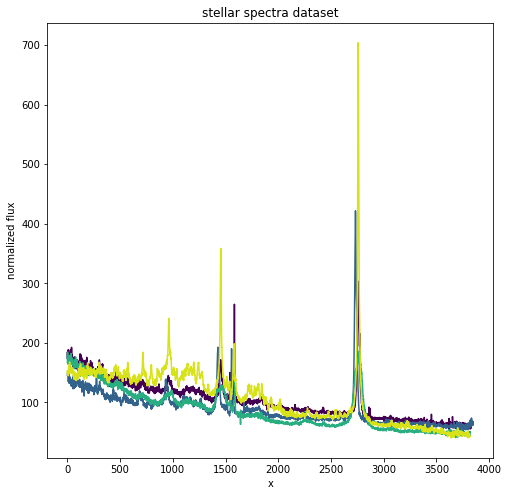

In [16]:
########################## first ploting option ################################################
norm = mpl.colors.Normalize(vmin=0, vmax=len(spectra_list)-1)
cmap = cm.viridis
m = cm.ScalarMappable(norm=norm, cmap=cmap)

plt.figure(1, figsize=(8, 8))
plt.title("stellar spectra dataset")
for i in range(0, len(spectra_list), 5):
    plt.plot(spectra_list[i] + i*0.2, color=m.to_rgba(i))
plt.xlabel("x")
plt.ylabel("normalized flux")

In [17]:
spectra_matrix = dfx2.to_numpy()

In [18]:
# load the spectra and construct the wavelength range 
wavelength = np.arange(4000, 7851, 1)
print(wavelength.shape, spectra_matrix.shape)

(3851,) (17, 3851)


In [19]:
indices_for_plot = numpy.arange(len(spectra_matrix))
X, Y = np.meshgrid(wavelength, indices_for_plot)

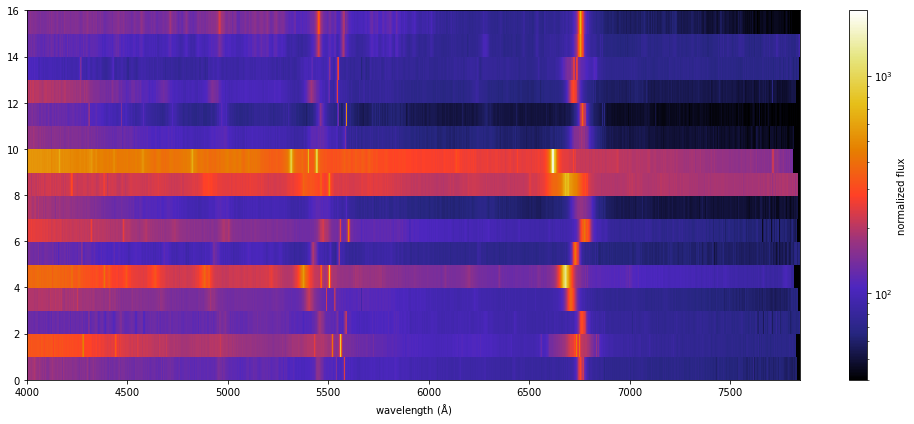

In [20]:
plt.figure(1, figsize=(14, 6))
plt.pcolormesh(X, Y, spectra_matrix.clip(40, 20000), cmap="CMRmap", norm=LogNorm())
plt.xlabel("wavelength ($\\mathrm{\\AA}$)")
plt.colorbar(label="normalized flux")
plt.tight_layout()

In [21]:
## Normalizing dataset (Min-Max normalization)
spectrum = spectra_matrix.data
n1 = spectrum - numpy.min(spectrum)
n2 = numpy.max(spectrum) - numpy.min(spectrum)
norm_spectrum = n1/n2
## adding offset
norm_spectrum = norm_spectrum +1

In [22]:
print('avg', numpy.median(spectrum))
print('max', numpy.max(spectrum))
print('min', numpy.min(spectrum))

avg 97.5438232421875
max 1996.207763671875
min 0.0


In [23]:
print('avg', numpy.median(norm_spectrum))
print('max', numpy.max(norm_spectrum))
print('min', numpy.min(norm_spectrum))

avg 1.048864564609629
max 2.0
min 1.0


In [24]:
#Parametros del secuenciador, tanto metricas como escalas
estimator_list = ['EMD','energy', 'L2', 'KL']
#scale_list = [[1,2,10], [1,2,10], [1,2,10]]

In [25]:
seq = Sequencer(wavelength, norm_spectrum, estimator_list)
output_path = "/root/"
final_elongation, final_sequence = seq.execute(output_path, to_average_N_best_estimators=True, 
                                              number_of_best_estimators=3,)
print("resulting elongation for the Sequencer: ", final_elongation)

# print the intermediate elongations for different metrics + scales
estimator_list, scale_list, elongation_list = seq.return_elongation_of_weighted_products_all_metrics_and_scales()

print("Intermediate elongations for the different metrics and scales:")
for i in range(len(estimator_list)):
    print("metric=%s, scale=%s, elongation: %s" % (estimator_list[i], 
                                                   scale_list[i], 
                                                   numpy.round(elongation_list[i], 2)))

# order the input dataset according to the detected sequence
objects_list_ordered = spectra_matrix[final_sequence]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


calculating the distance matrices for estimator: EMD, scale: 1
finished calculating this distance matrix list, it took: 0.10915350914001465 seconds
calculating the distance matrices for estimator: EMD, scale: 2
finished calculating this distance matrix list, it took: 0.12578153610229492 seconds
calculating the distance matrices for estimator: EMD, scale: 4
finished calculating this distance matrix list, it took: 0.14672183990478516 seconds
calculating the distance matrices for estimator: EMD, scale: 8
finished calculating this distance matrix list, it took: 0.21555757522583008 seconds
calculating the distance matrices for estimator: EMD, scale: 16
finished calculating this distance matrix list, it took: 0.3242487907409668 seconds
calculating the distance matrices for estimator: EMD, scale: 32
finished calculating this distance matrix list, it took: 0.5152437686920166 seconds
calculating the distance matrices for estimator: EMD, scale: 64
finished calculating this distance matrix list, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:896: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


in estimator: EMD, scale: 64
in estimator: EMD, scale: 128
in estimator: energy, scale: 1
in estimator: energy, scale: 2
in estimator: energy, scale: 4
in estimator: energy, scale: 8
in estimator: energy, scale: 16
in estimator: energy, scale: 32
in estimator: energy, scale: 64
in estimator: energy, scale: 128
in estimator: L2, scale: 1
in estimator: L2, scale: 2
in estimator: L2, scale: 4
in estimator: L2, scale: 8
in estimator: L2, scale: 16
in estimator: L2, scale: 32
in estimator: L2, scale: 64
in estimator: L2, scale: 128
in estimator: KL, scale: 1
in estimator: KL, scale: 2
in estimator: KL, scale: 4
in estimator: KL, scale: 8
in estimator: KL, scale: 16
in estimator: KL, scale: 32
in estimator: KL, scale: 64
in estimator: KL, scale: 128
dumped the elongations to the file: /root//elongations.pkl
dumped the full weighted distance matrix to the file: /root//weighted_distance_matrix.pkl
dumped the sparse distance matrix to the file: <_io.BufferedWriter name='/root//sparse_distance_m

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1024: RuntimeWarning: divide by zero encountered in true_divide


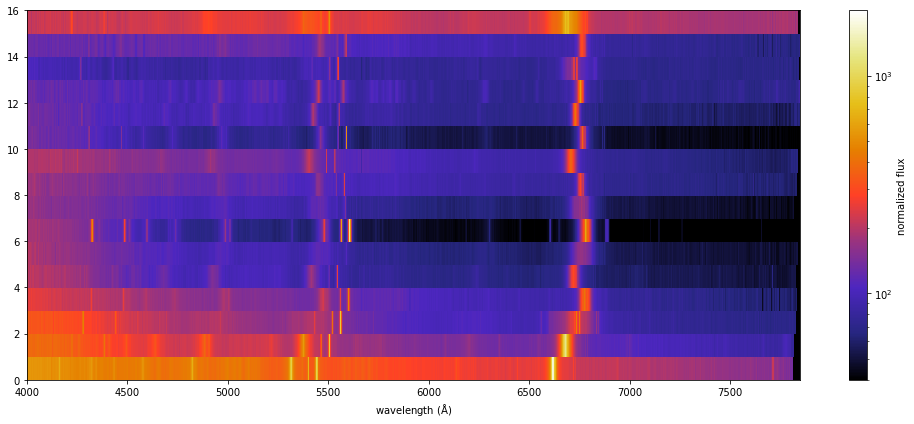

In [26]:
# plot the ordered dataset
plt.figure(1, figsize=(14, 6))
plt.pcolormesh(X, Y, objects_list_ordered.clip(40, 20000), cmap="CMRmap", norm=LogNorm())
plt.xlabel("wavelength ($\\mathrm{\\AA}$)")
plt.colorbar(label="normalized flux")
plt.tight_layout()

In [27]:
##### comparison ######

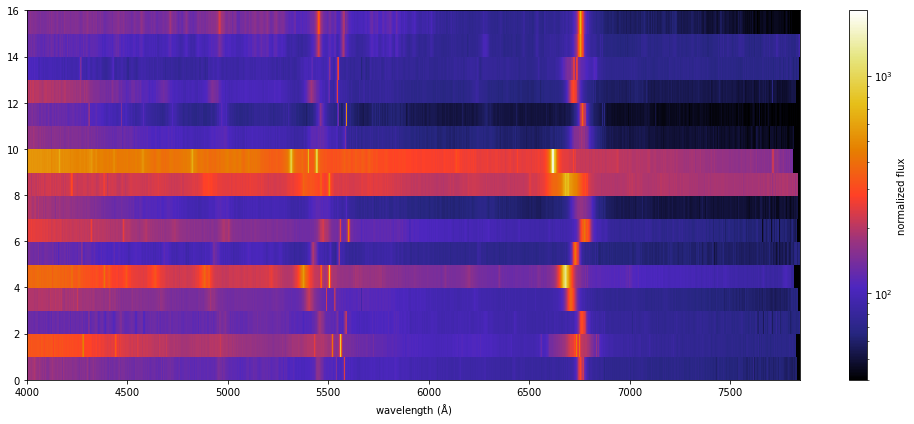

In [28]:
plt.figure(1, figsize=(14, 6))
plt.pcolormesh(X, Y, spectra_matrix.clip(40, 20000), cmap="CMRmap", norm=LogNorm())
plt.xlabel("wavelength ($\\mathrm{\\AA}$)")
plt.colorbar(label="normalized flux")
plt.tight_layout()